<a href="https://colab.research.google.com/github/SusieZhan/Housing-Price-Prediction/blob/master/HousingPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2930 non-null   int64  
 1   MS Zoning        2930 non-null   object 
 2   Lot Frontage     2440 non-null   float64
 3   Lot Area         2930 non-null   int64  
 4   Street           2930 non-null   object 
 5   Alley            198 non-null    object 
 6   Lot Shape        2930 non-null   object 
 7   Land Contour     2930 non-null   object 
 8   Utilities        2930 non-null   object 
 9   Lot Config       2930 non-null   object 
 10  Land Slope       2930 non-null   object 
 11  Neighborhood     2930 non-null   object 
 12  Condition 1      2930 non-null   object 
 13  Condition 2      2930 non-null   object 
 14  Bldg Type        2930 non-null   object 
 15  House Style      2930 non-null   object 
 16  Overall Qual     2930 non-null   int64  
 17  Overall Cond  

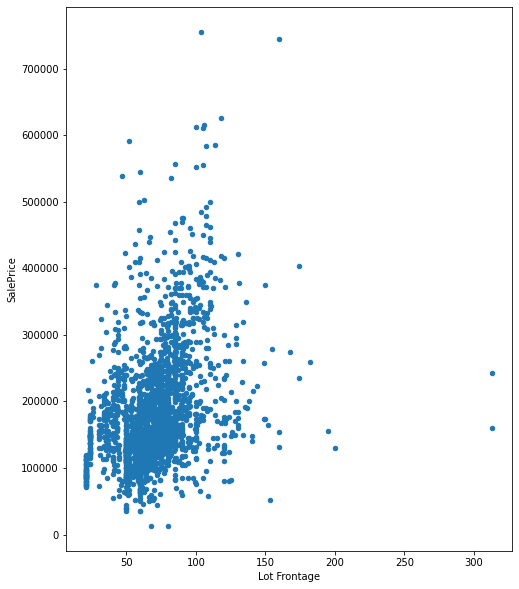

Lot Area


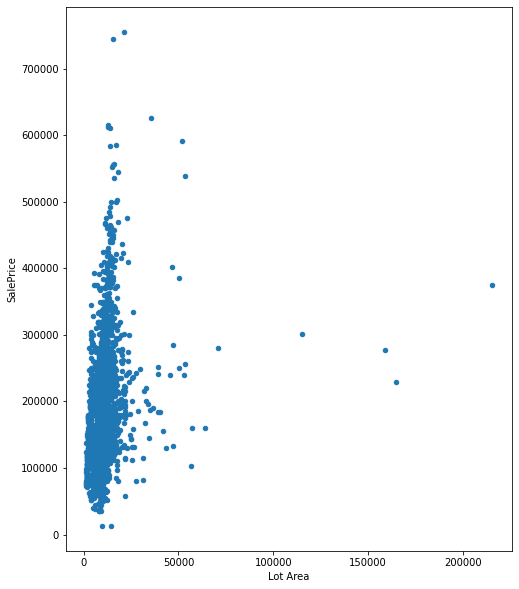

Year Built


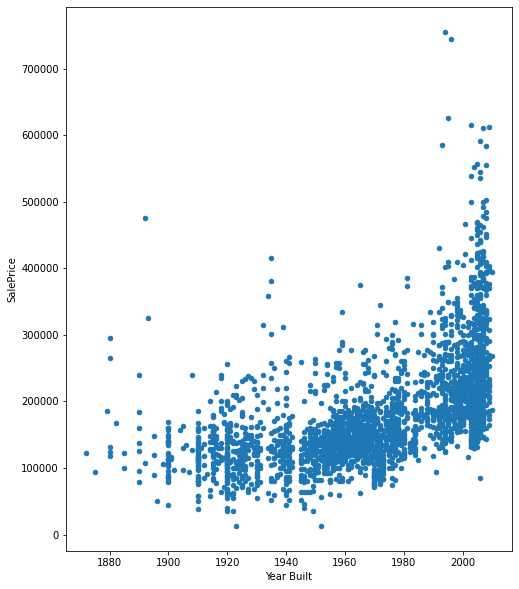

Year Remod/Add


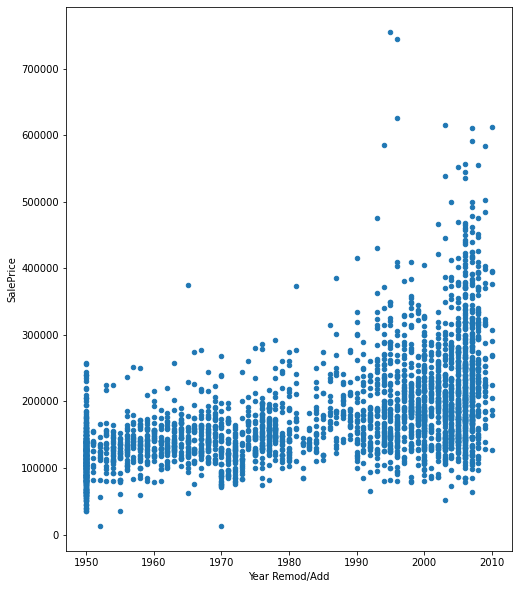

Mas Vnr Area


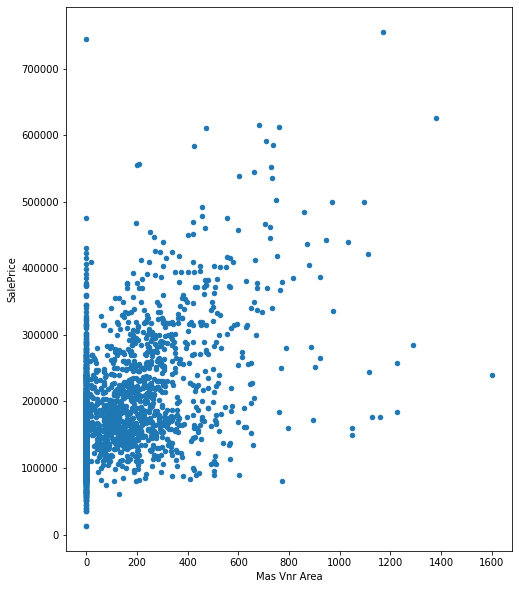

BsmtFin SF 1


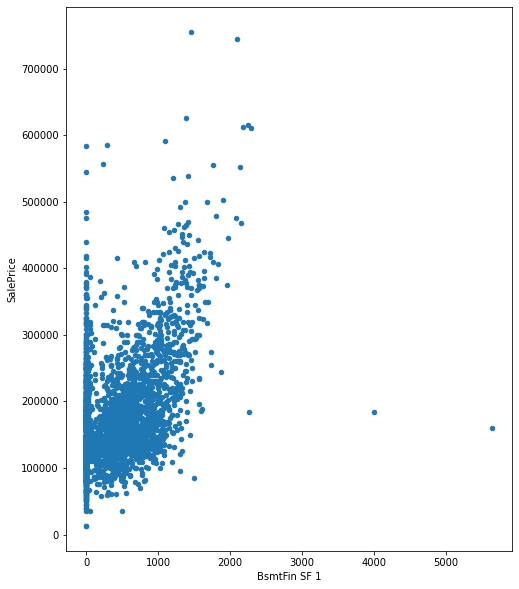

BsmtFin SF 2


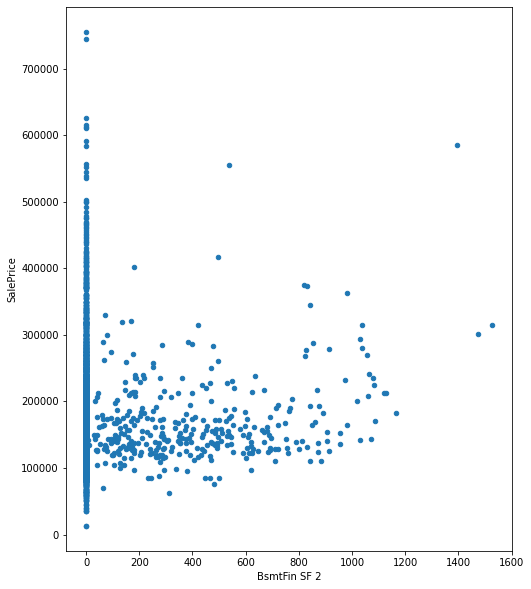

Bsmt Unf SF


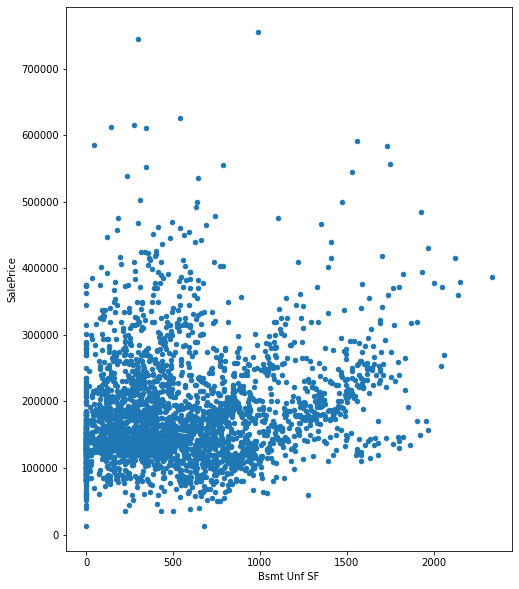

Total Bsmt SF


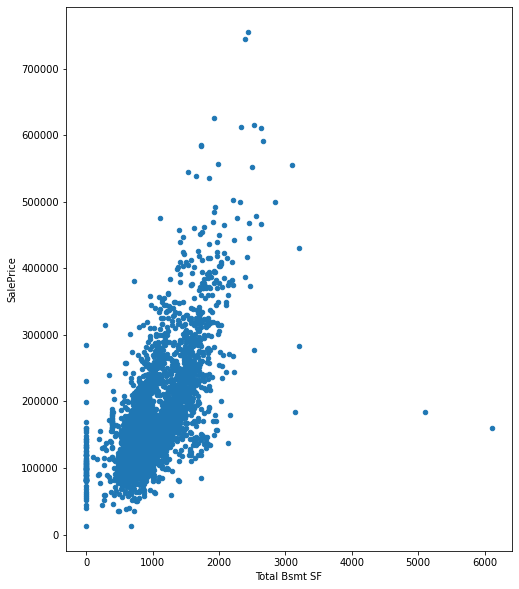

1st Flr SF


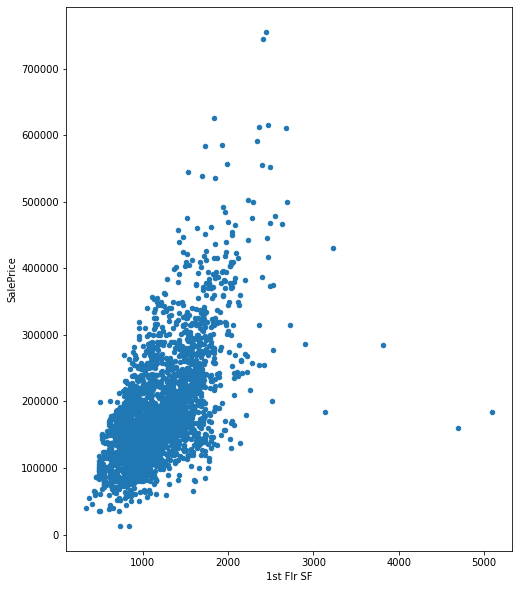

2nd Flr SF


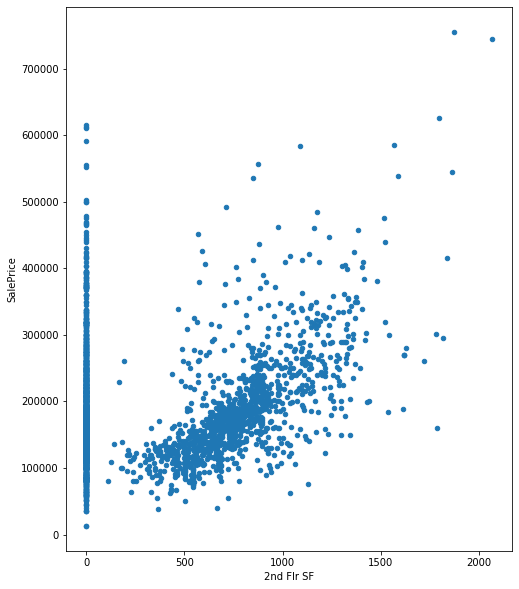

Low Qual Fin SF


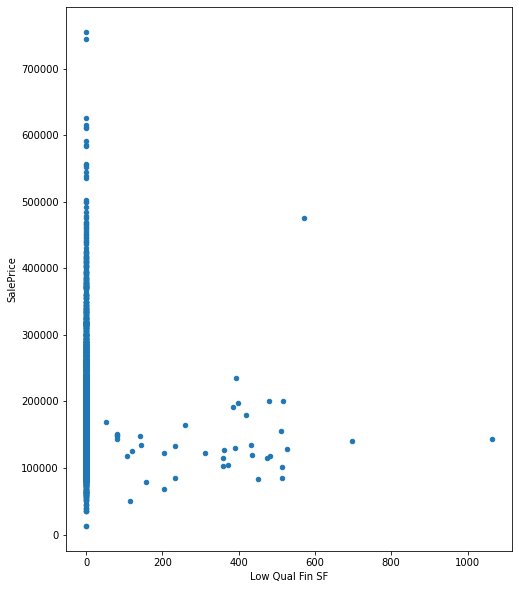

Gr Liv Area


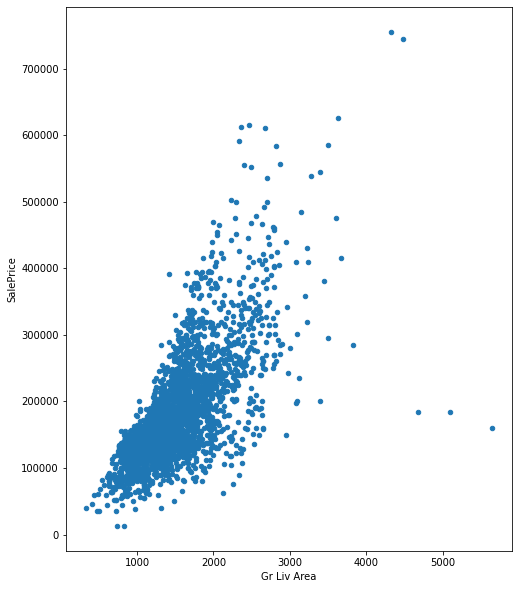

Bsmt Full Bath


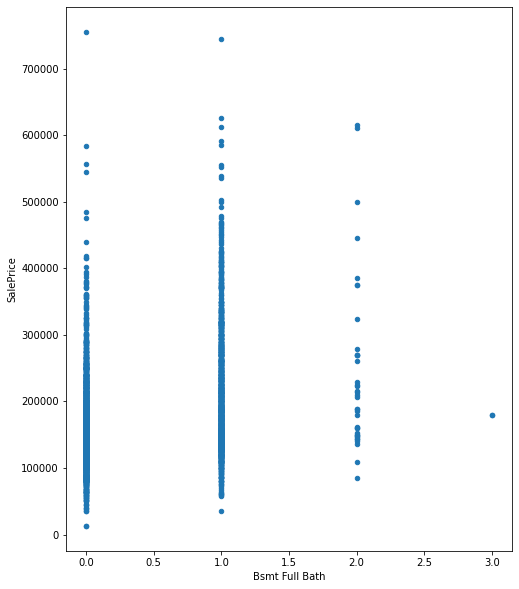

Bsmt Half Bath


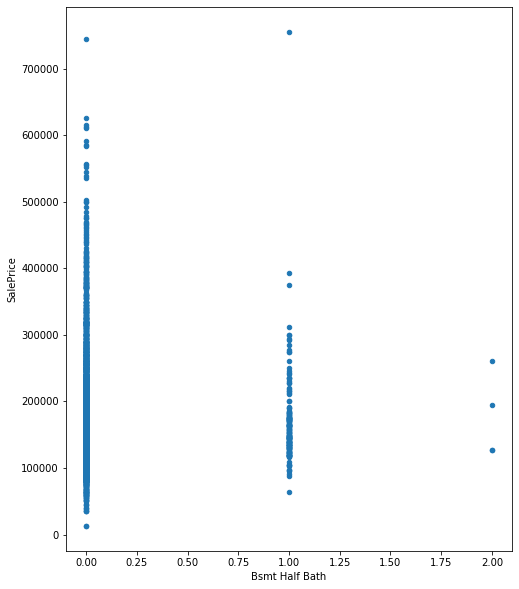

Full Bath


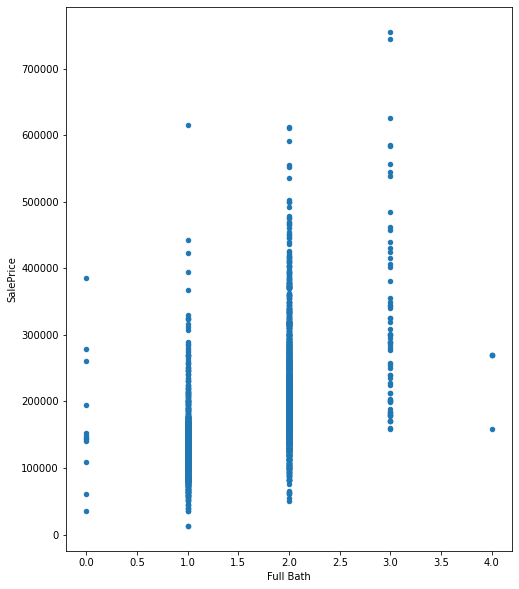

Half Bath


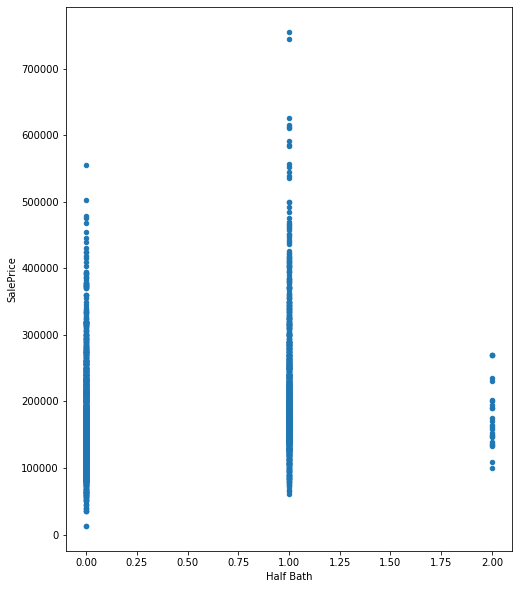

Bedroom AbvGr


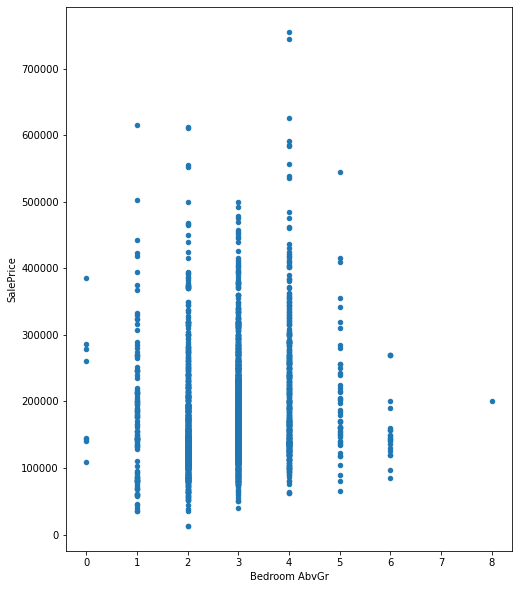

Kitchen AbvGr


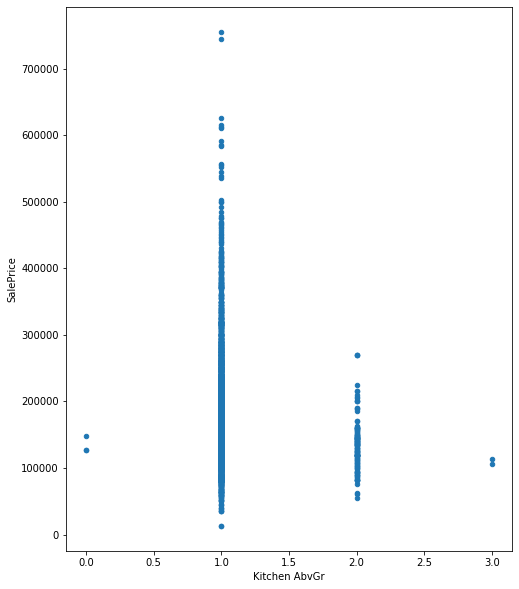

TotRms AbvGrd


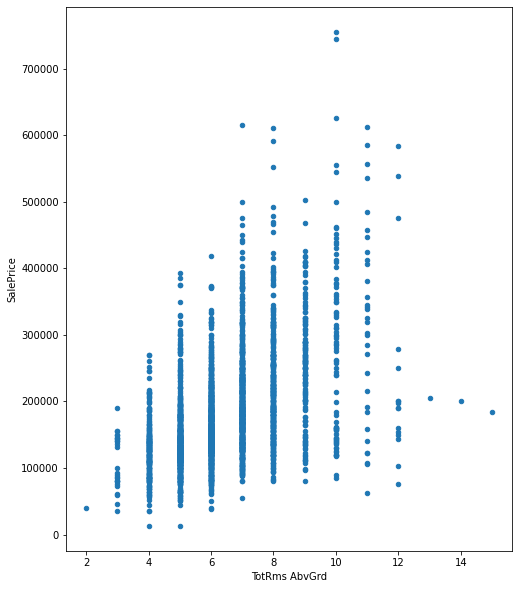

Fireplaces


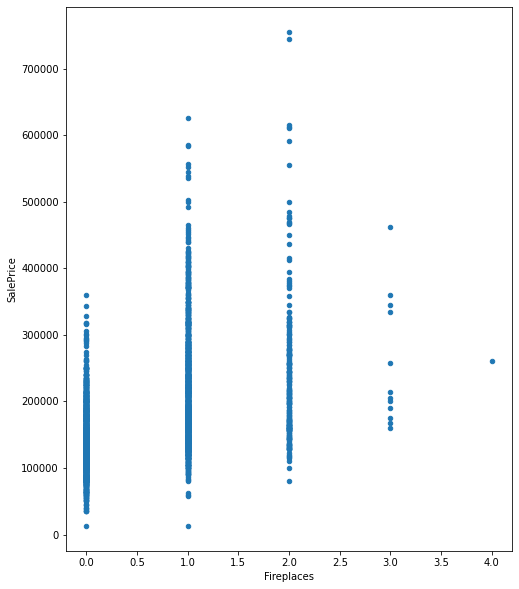

Garage Yr Blt


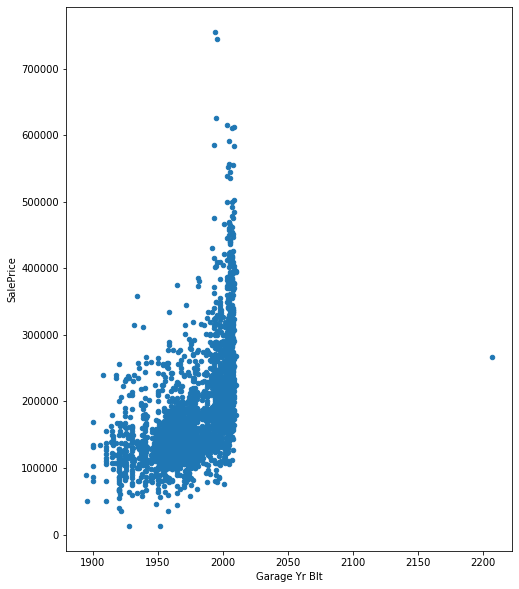

Garage Cars


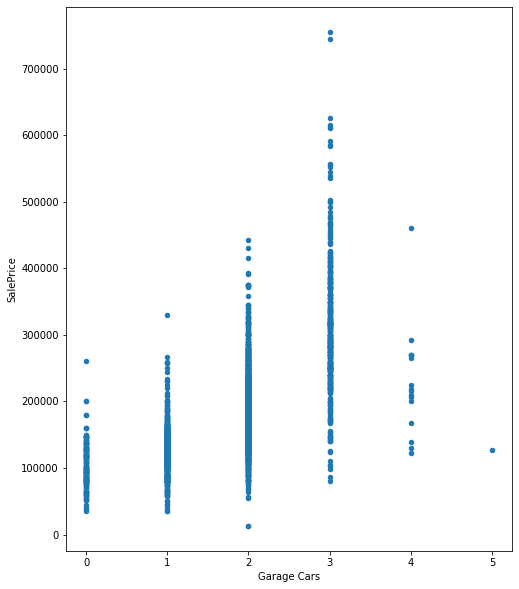

Garage Area


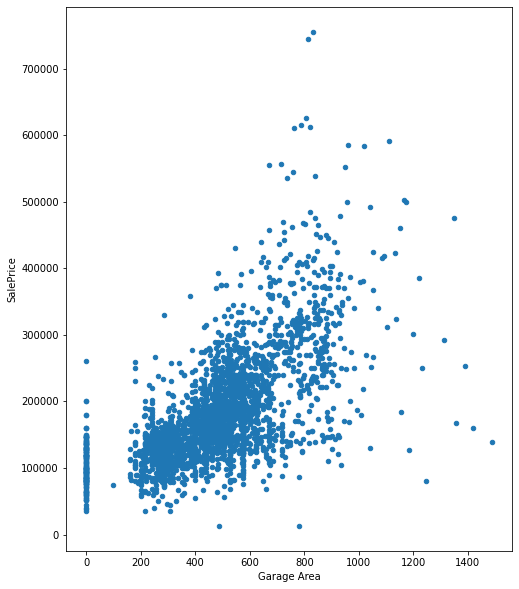

Wood Deck SF


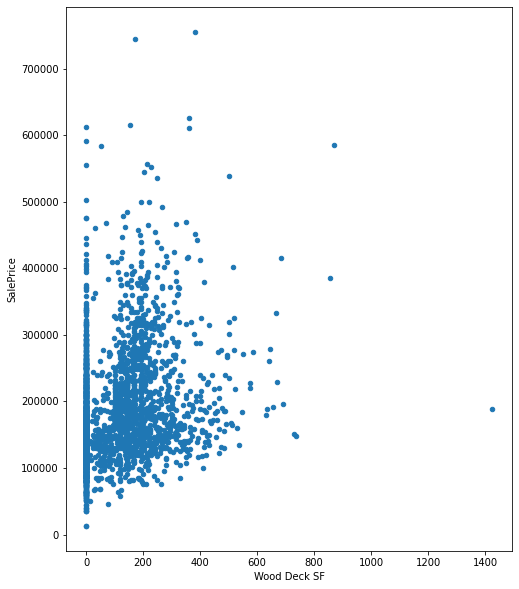

Open Porch SF


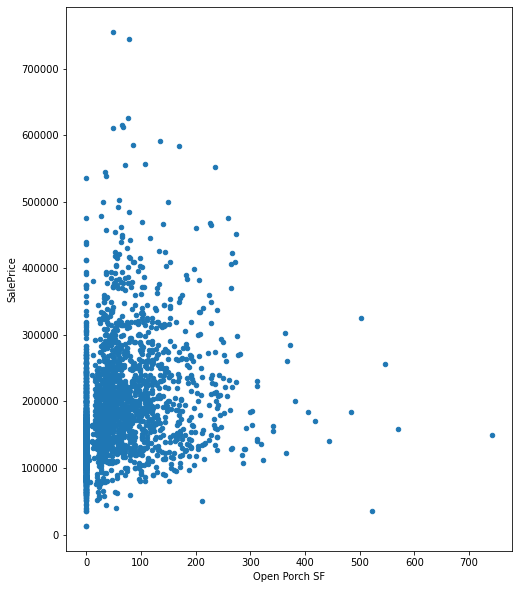

Enclosed Porch


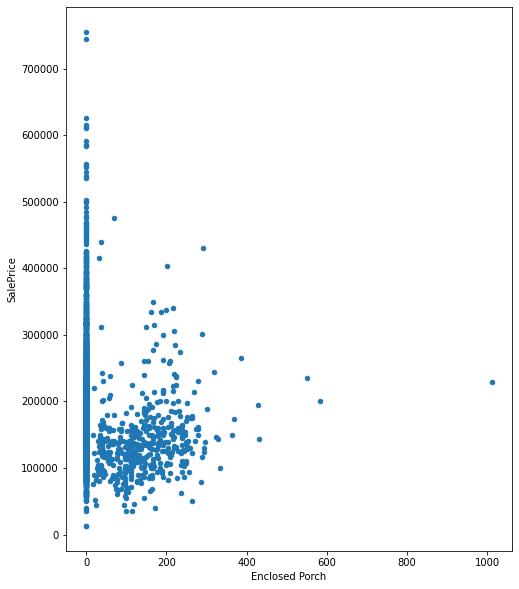

3Ssn Porch


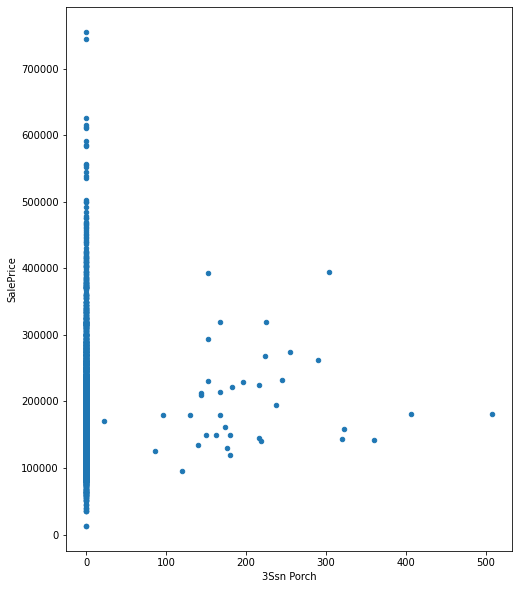

Screen Porch


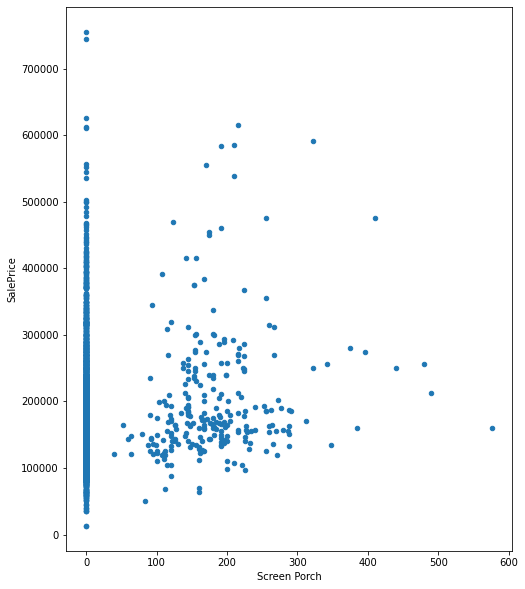

Pool Area


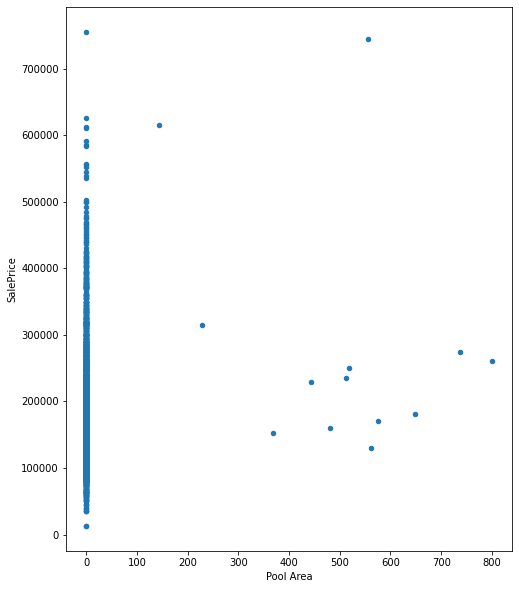

Misc Val


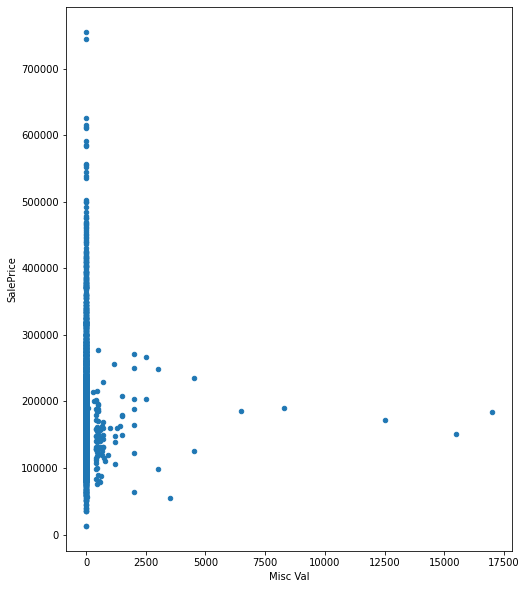

Mo Sold


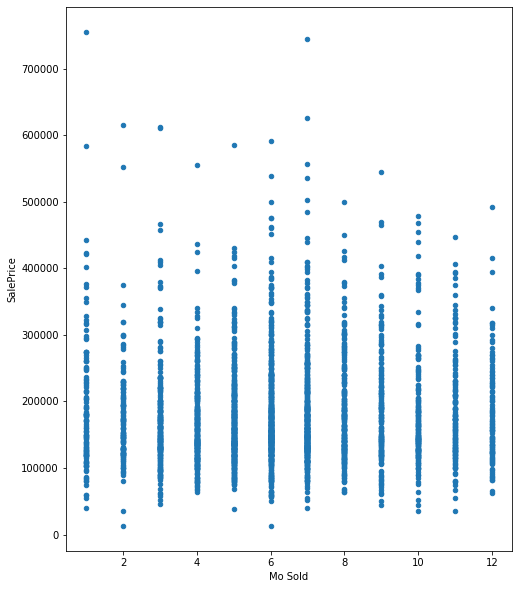

Yr Sold


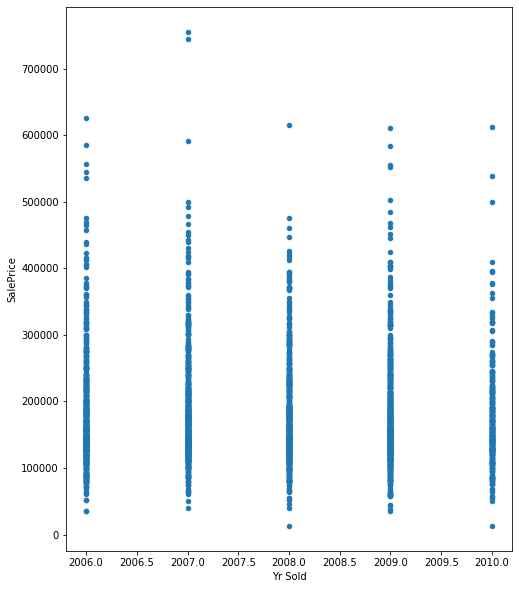

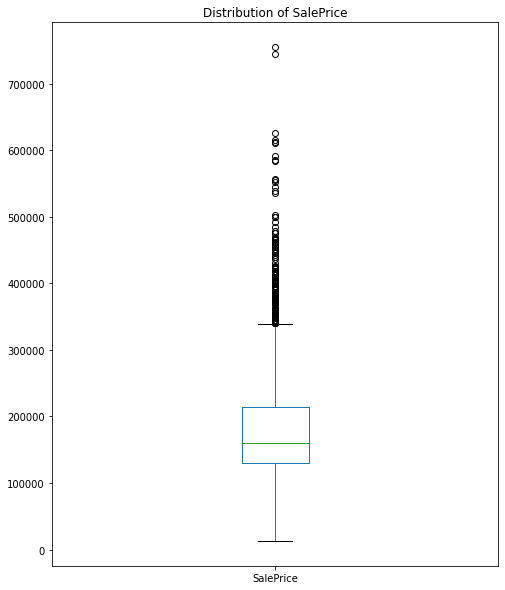

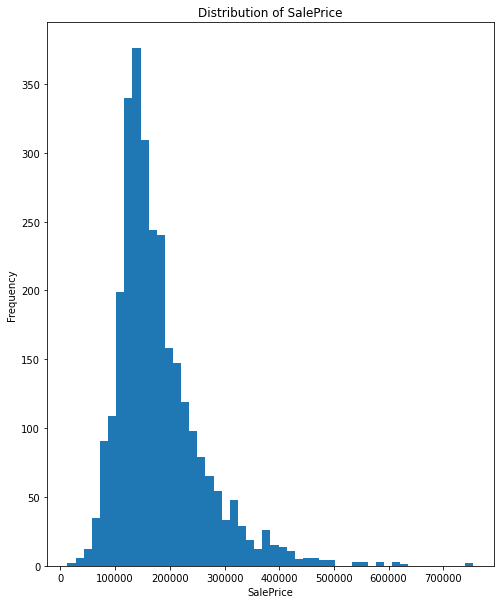

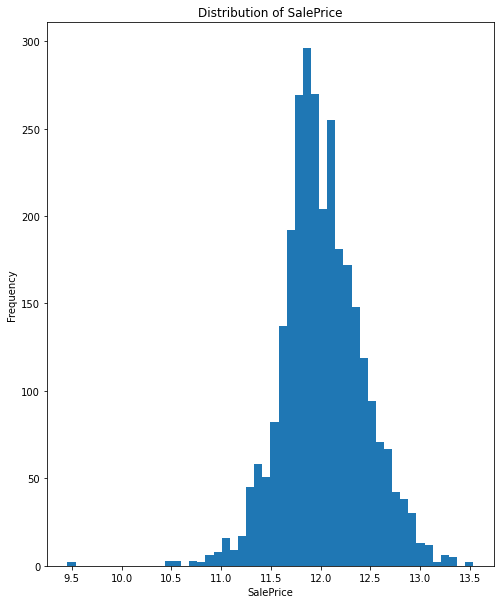

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


housing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 75 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS SubClass      2930 non-null   category
 1   MS Zoning        2930 non-null   category
 2   Lot Frontage     2440 non-null   float64 
 3   Lot Area         2930 non-null   int64   
 4   Street           2930 non-null   category
 5   Lot Shape        2930 non-null   category
 6   Land Contour     2930 non-null   category
 7   Utilities        2930 non-null   category
 8   Lot Config       2930 non-null   category
 9   Land Slope       2930 non-null   category
 10  Neighborhood     2930 non-null   category
 11  Condition 1      2930 non-null   category
 12  Condition 2      2930 non-null   category
 13  Bldg Type        2930 non-null   category
 14  House Style      2930 non-null   category
 15  Overall Qual     2930 non-null   category
 16  Overall Cond     2930 non-null   c

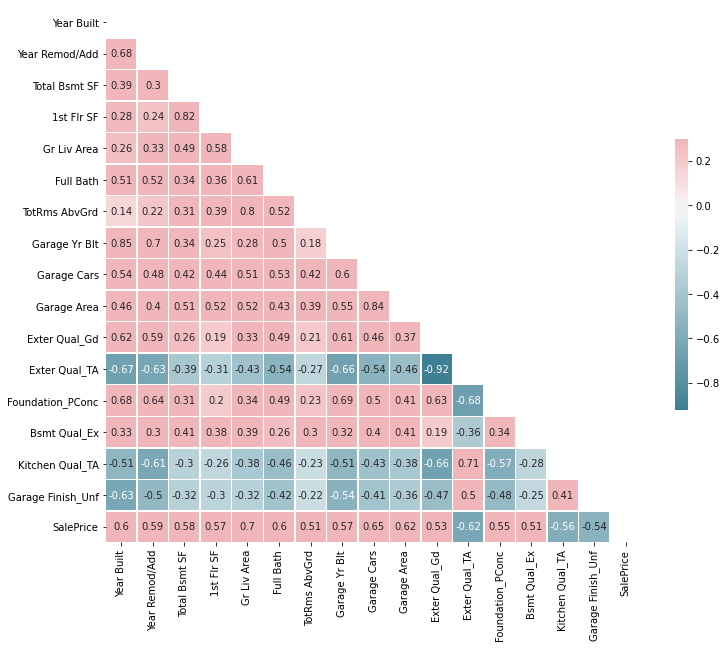

Pearson Correlation Selected Features: Index(['Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'Full Bath',
       'Garage Cars', 'Exter Qual_Gd', 'Foundation_PConc', 'Bsmt Qual_Ex',
       'Kitchen Qual_TA', 'Garage Finish_Unf'],
      dtype='object')

KNN Stepwise Selected Features: ('Lot Frontage', 'Year Built', 'Year Remod/Add', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Yr Blt', '3Ssn Porch', 'Mo Sold', 'BsmtFin Type 1_Rec')
Mean Squared Error: 0.04403746621184147

Best alpha using built-in LassoCV: 1.000000
Best score using built-in LassoCV: 0.734325
Lasso picked 14 variables and eliminated the other 312 variables
Variables    Coefficient
Misc Val         -5.757770e-05
Pool Area        -2.214532e-06
Lot Area          2.844094e-07
BsmtFin SF 2      1.383030e-06
1st Flr SF        1.754299e-06
BsmtFin SF 1      2.856952e-05
Mas Vnr Area      7.894026e-05
Total Bsmt SF     1.342965e-04
Wood Deck SF      1.855589e-04
Screen Porch      2.381339e-04
Garage Area       2.818546e

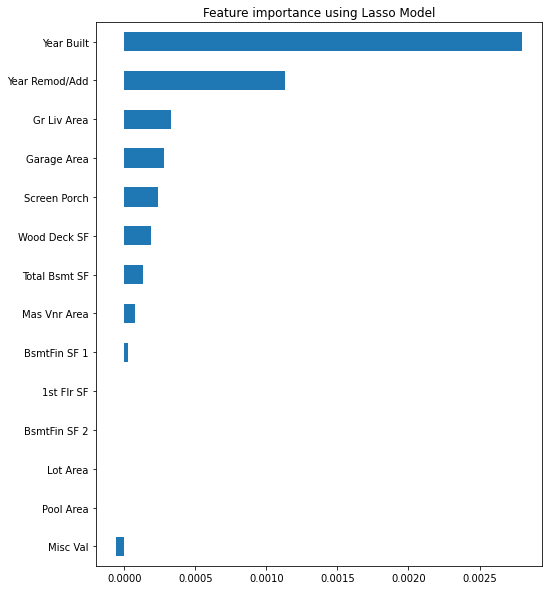


Best alpha using built-in ElasticNetCV: 1.000000
Best l1_ratio using built-in ElasticNetCV: 0.500000
Best score using built-in ElasticNetCV: 0.753964
ElasticNet picked 15 variables and eliminated the other 311 variables
Variables    Coefficient
Pool Area        -2.150481e-04
Misc Val         -5.829804e-05
Lot Area          7.295254e-07
1st Flr SF        1.770955e-05
BsmtFin SF 2      2.842193e-05
BsmtFin SF 1      3.555776e-05
Mas Vnr Area      8.137551e-05
Enclosed Porch    1.077002e-04
Total Bsmt SF     1.091158e-04
Wood Deck SF      2.018653e-04
Garage Area       2.393858e-04
Gr Liv Area       3.188151e-04
Screen Porch      4.400712e-04
Year Remod/Add    2.418186e-03
Year Built        3.085943e-03
dtype: float64


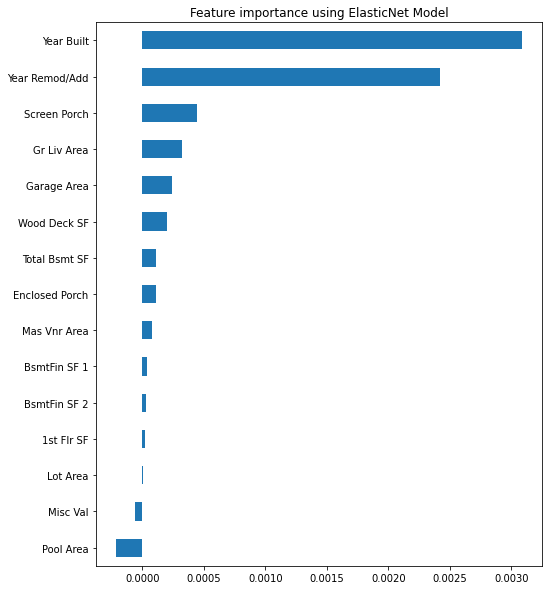


Random Forest picked 
Variable: Gr Liv Area               Importance: 0.25
Variable: Year Built                Importance: 0.18
Variable: Exter Qual_TA             Importance: 0.15
Variable: 1st Flr SF                Importance: 0.04
Variable: Garage Area               Importance: 0.04
Variable: Bsmt Qual_Ex              Importance: 0.04
Variable: Total Bsmt SF             Importance: 0.03
Variable: Fireplaces                Importance: 0.03
Variable: Garage Cars               Importance: 0.03
Variable: Year Remod/Add            Importance: 0.02

Linear Regression

Mean Squared Error: 0.041086772685055326
Fitting linear regression

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


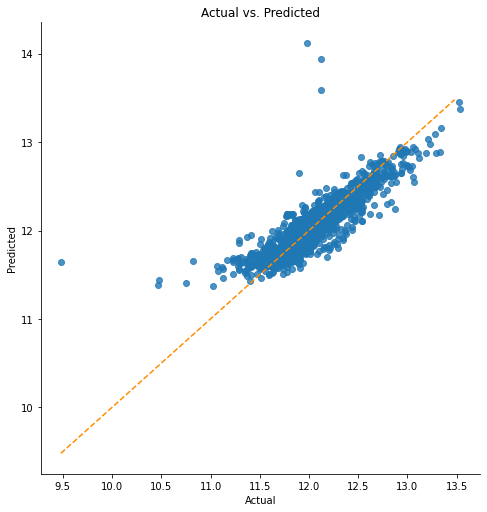

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed



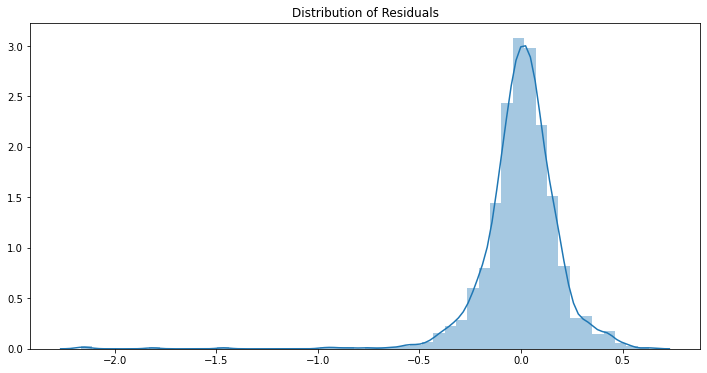

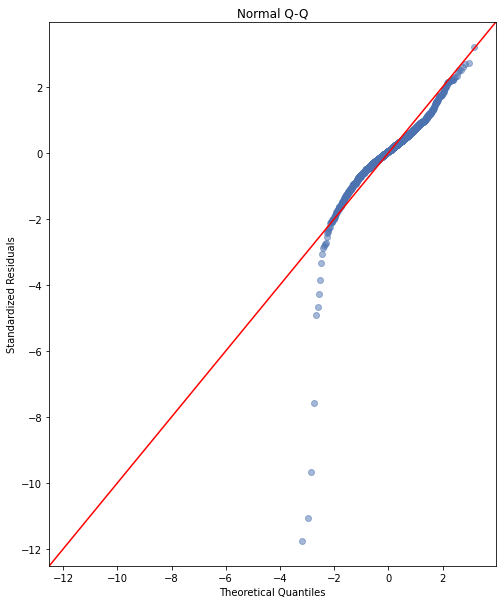


Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Year Built: 32.39781581654835
Total Bsmt SF: 10.098032193025151
Gr Liv Area: 18.649038598715503
Full Bath: 18.788092725524066
Garage Cars: 17.376832936365062
Exter Qual_Gd: 3.6513113878835304
Foundation_PConc: 3.9234578929472814
Bsmt Qual_Ex: 1.5406883354102963
Kitchen Qual_TA: 3.9907042387395784
Garage Finish_Unf: 2.5867990927573703

5 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to

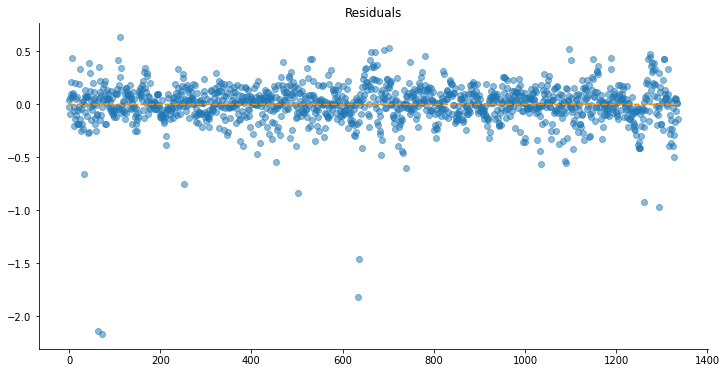

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

KNN Regression

Best parameter: {'n_neighbors': 5}
Mean Squared Error: 0.04403746621184147

Lasso Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.04713121224049754

ElasticNet Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.04640377879689049

Random Forest Regression

Best parameter: {'n_estimators': 1000}
Mean Squared Error: 0.026852309827035275
                                mse        r2       mae         v
linear_regression         0.0269131  0.824673  0.116818  0.824928
knn_regression            0.0354963  0.768757   0.13462  0.769452
lasso_regression          0.0255823  0.833343  0.115053  0.833353
elasticnet_regression     0.0258381  0.831676  0.115655  0.831714
random_forest_regression  0.0211993  0.861896  0.104181  0.861931

Feature Selection

Year Built           0.591238
Year Remod/Add       0.578655
Total Bsmt SF        0.587252
1st Flr SF       

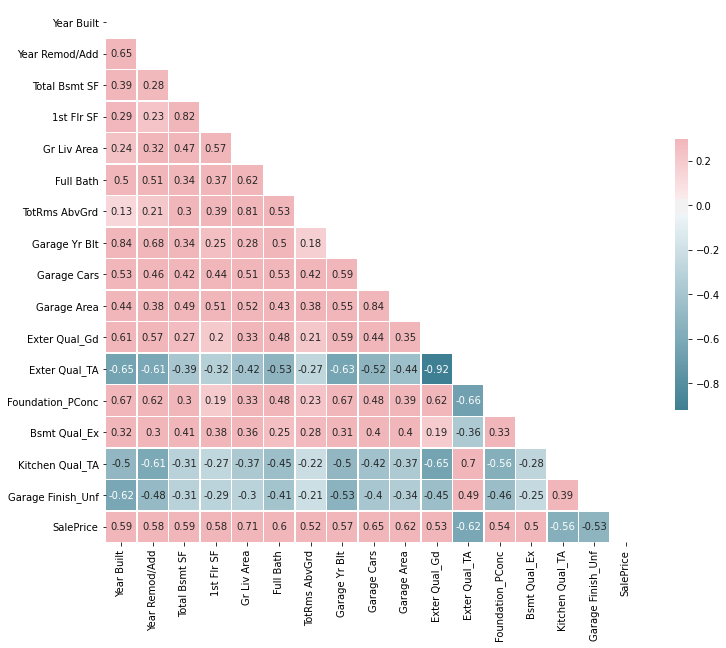

Pearson Correlation Selected Features: Index(['Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'Full Bath',
       'Garage Cars', 'Exter Qual_Gd', 'Foundation_PConc', 'Bsmt Qual_Ex',
       'Kitchen Qual_TA', 'Garage Finish_Unf'],
      dtype='object')

KNN Stepwise Selected Features: ('Lot Frontage', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Yr Blt', '3Ssn Porch', 'Pool Area', 'Misc Val')
Mean Squared Error: 0.0400768232129449

Best alpha using built-in LassoCV: 1.000000
Best score using built-in LassoCV: 0.741131
Lasso picked 13 variables and eliminated the other 313 variables
Variables    Coefficient
Misc Val         -5.239157e-05
Lot Area          2.696796e-07
1st Flr SF        6.122086e-06
BsmtFin SF 2      1.058823e-05
BsmtFin SF 1      3.959635e-05
Mas Vnr Area      7.358518e-05
Total Bsmt SF     1.401064e-04
Wood Deck SF      1.520654e-04
Screen Porch      1.640004e-04
Garage Area       2.833600e-04
Gr Liv Area       3.302140e-04
Ye

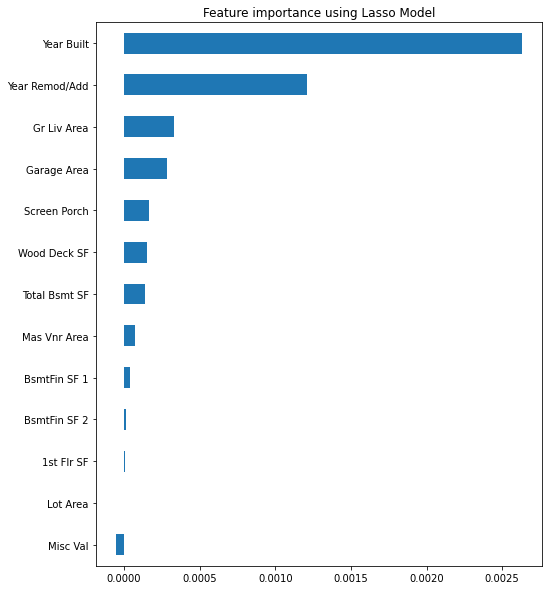


Best alpha using built-in ElasticNetCV: 1.000000
Best l1_ratio using built-in ElasticNetCV: 0.500000
Best score using built-in ElasticNetCV: 0.760243
ElasticNet picked 15 variables and eliminated the other 311 variables
Variables    Coefficient
Pool Area        -1.902540e-04
Misc Val         -5.315119e-05
Lot Area          7.321898e-07
1st Flr SF        2.112573e-05
BsmtFin SF 2      3.872817e-05
BsmtFin SF 1      4.392648e-05
Enclosed Porch    6.770987e-05
Mas Vnr Area      7.496732e-05
Total Bsmt SF     1.162325e-04
Wood Deck SF      1.681235e-04
Garage Area       2.454087e-04
Gr Liv Area       3.192371e-04
Screen Porch      3.629325e-04
Year Remod/Add    2.455699e-03
Year Built        2.912141e-03
dtype: float64


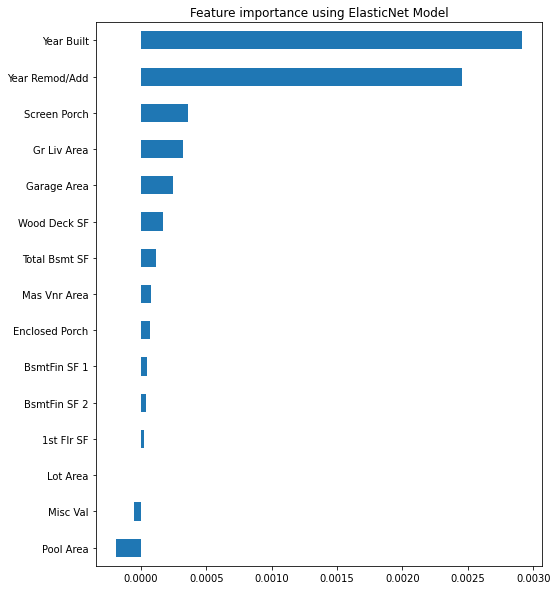


Random Forest picked 
Variable: Gr Liv Area               Importance: 0.28
Variable: Year Built                Importance: 0.15
Variable: Exter Qual_TA             Importance: 0.14
Variable: 1st Flr SF                Importance: 0.05
Variable: Bsmt Qual_Ex              Importance: 0.05
Variable: Total Bsmt SF             Importance: 0.04
Variable: Garage Area               Importance: 0.04
Variable: Garage Cars               Importance: 0.03
Variable: Lot Area                  Importance: 0.02
Variable: Year Remod/Add            Importance: 0.02
Variable: Fireplaces                Importance: 0.02

Linear Regression

Mean Squared Error: 0.038852067302554846
Fitting linear regression

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


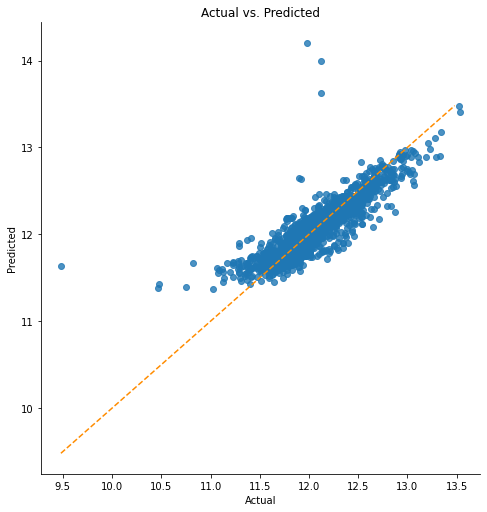

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed



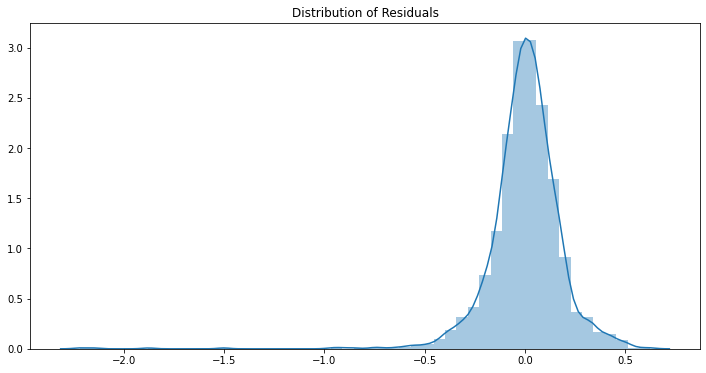

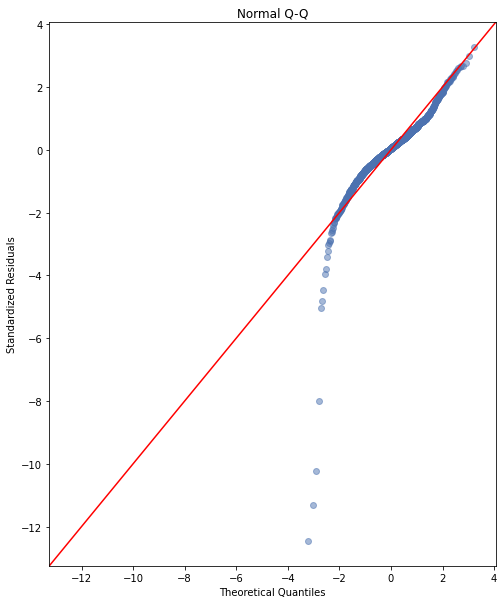


Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Year Built: 31.917350481055273
Total Bsmt SF: 10.402871481417233
Gr Liv Area: 18.605697998870205
Full Bath: 18.8905325181818
Garage Cars: 16.80843498669195
Exter Qual_Gd: 3.46157068349375
Foundation_PConc: 3.7538848877836455
Bsmt Qual_Ex: 1.5091637614503919
Kitchen Qual_TA: 3.938553526251355
Garage Finish_Unf: 2.5515831710013237

5 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is

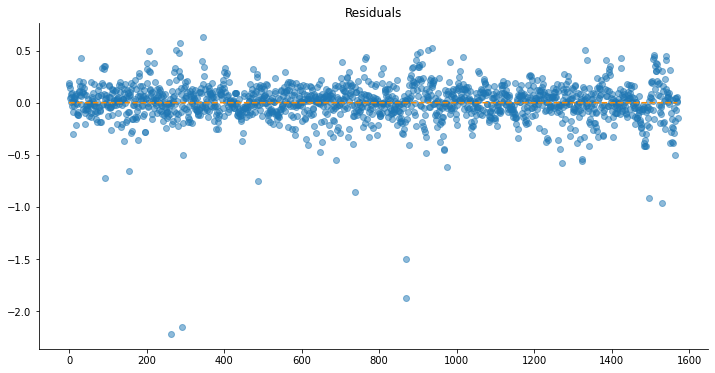

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

KNN Regression

Best parameter: {'n_neighbors': 5}
Mean Squared Error: 0.0400768232129449

Lasso Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.04234933031945311

ElasticNet Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.04230673794911645

Random Forest Regression

Best parameter: {'n_estimators': 500}
Mean Squared Error: 0.025615976378701676
                                mse        r2       mae         v
linear_regression         0.0282271  0.825511  0.119811  0.827128
knn_regression            0.0326267  0.798314  0.129871   0.80127
lasso_regression          0.0274276  0.830453   0.11969  0.833313
elasticnet_regression     0.0282064  0.825639  0.121322  0.828475
random_forest_regression  0.0237973  0.852894  0.105811  0.857144

Feature Selection

Year Built           0.597479
Year Remod/Add       0.583761
Total Bsmt SF        0.598180
1st Flr SF         

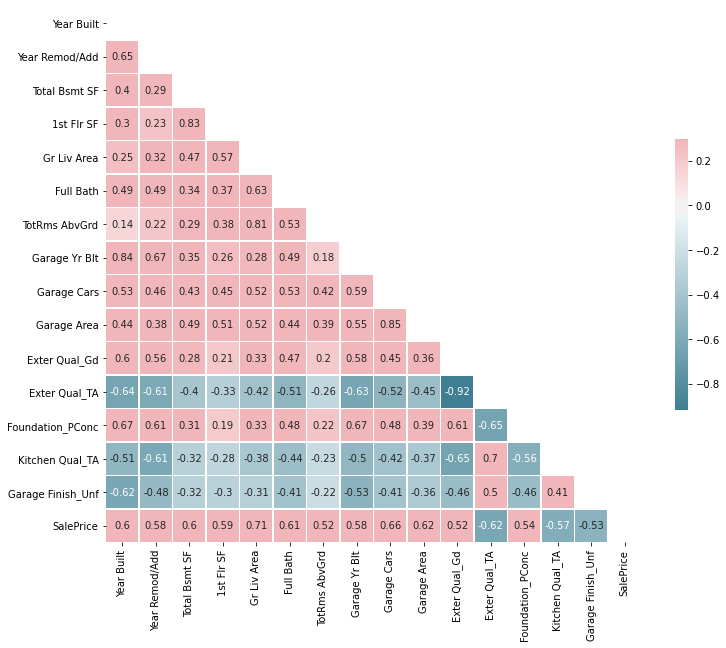

Pearson Correlation Selected Features: Index(['Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'Full Bath',
       'Garage Cars', 'Exter Qual_Gd', 'Foundation_PConc', 'Kitchen Qual_TA',
       'Garage Finish_Unf'],
      dtype='object')

KNN Stepwise Selected Features: ('Lot Frontage', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Yr Blt', '3Ssn Porch', 'Pool Area', 'Lot Config_Inside')
Mean Squared Error: 0.03918493554477771

Best alpha using built-in LassoCV: 1.000000
Best score using built-in LassoCV: 0.750863
Lasso picked 13 variables and eliminated the other 313 variables
Variables    Coefficient
Misc Val         -5.415551e-05
Lot Area          2.021507e-07
BsmtFin SF 2      2.737110e-06
1st Flr SF        6.436771e-06
BsmtFin SF 1      4.570880e-05
Mas Vnr Area      7.425411e-05
Screen Porch      1.333559e-04
Total Bsmt SF     1.494679e-04
Wood Deck SF      1.535902e-04
Garage Area       2.761375e-04
Gr Liv Area       3.351916e-04
Year Rem

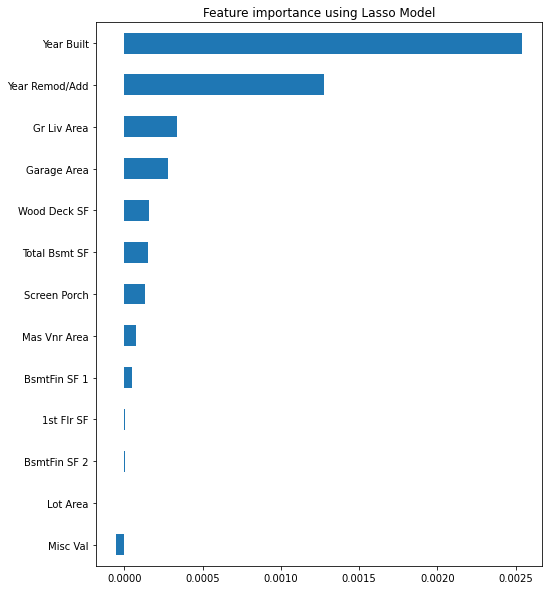


Best alpha using built-in ElasticNetCV: 1.000000
Best l1_ratio using built-in ElasticNetCV: 0.500000
Best score using built-in ElasticNetCV: 0.768573
ElasticNet picked 15 variables and eliminated the other 311 variables
Variables    Coefficient
Pool Area        -1.295871e-04
Misc Val         -5.457766e-05
Lot Area          6.277553e-07
Enclosed Porch    1.251432e-05
1st Flr SF        2.099924e-05
BsmtFin SF 2      3.045785e-05
BsmtFin SF 1      4.874100e-05
Mas Vnr Area      7.762722e-05
Total Bsmt SF     1.251669e-04
Wood Deck SF      1.623757e-04
Garage Area       2.417279e-04
Gr Liv Area       3.233643e-04
Screen Porch      3.245279e-04
Year Remod/Add    2.536756e-03
Year Built        2.784955e-03
dtype: float64


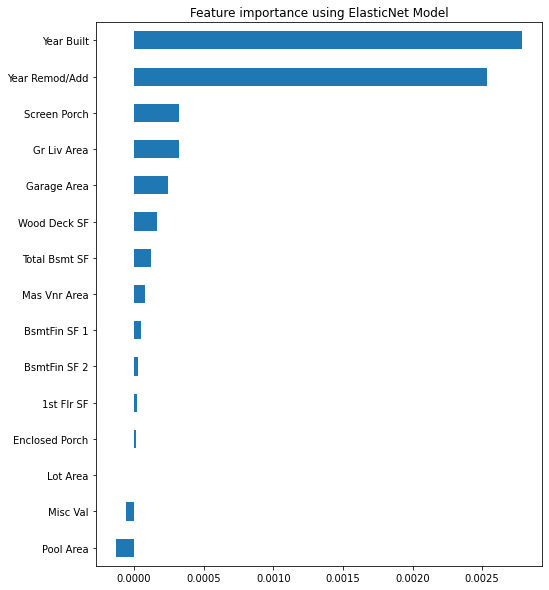


Random Forest picked 
Variable: Gr Liv Area               Importance: 0.27
Variable: Year Built                Importance: 0.23
Variable: Exter Qual_TA             Importance: 0.09
Variable: 1st Flr SF                Importance: 0.05
Variable: Total Bsmt SF             Importance: 0.04
Variable: Garage Area               Importance: 0.04
Variable: Fireplaces                Importance: 0.03
Variable: Garage Cars               Importance: 0.03
Variable: Bsmt Qual_Ex              Importance: 0.03
Variable: Lot Area                  Importance: 0.02
Variable: Year Remod/Add            Importance: 0.02

Linear Regression

Mean Squared Error: 0.039105288018540615
Fitting linear regression

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


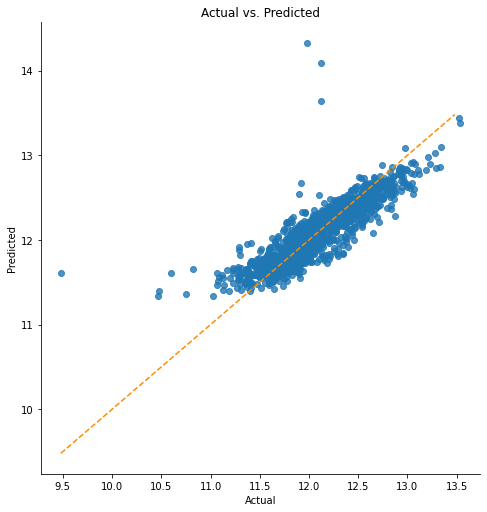

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed



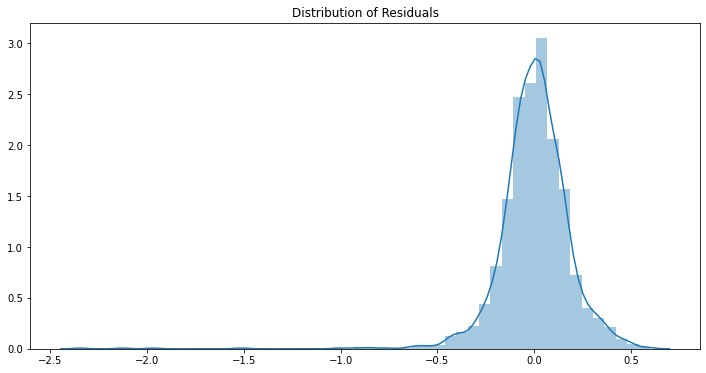

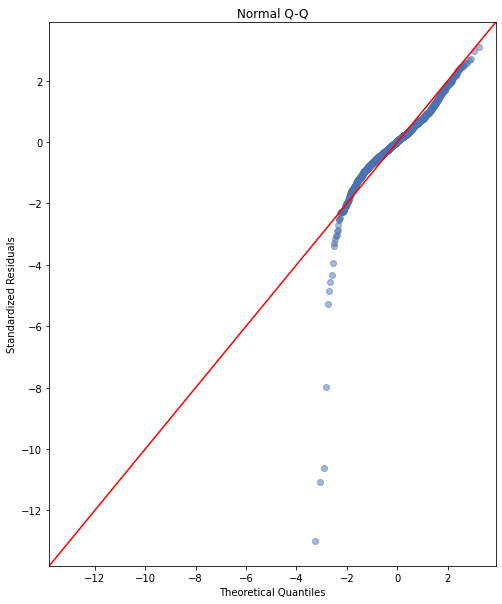


Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Year Built: 30.958317346277035
Total Bsmt SF: 10.015560133284295
Gr Liv Area: 18.886993988061292
Full Bath: 19.061264206185395
Garage Cars: 16.578364111676635
Exter Qual_Gd: 3.376764886398964
Foundation_PConc: 3.627278902280357
Kitchen Qual_TA: 3.9208025329460026
Garage Finish_Unf: 2.5894034744154037

5 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
---

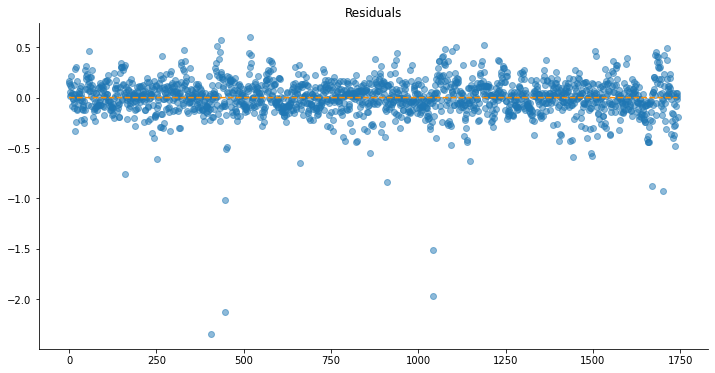

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

KNN Regression

Best parameter: {'n_neighbors': 4}
Mean Squared Error: 0.03894325291410292

Lasso Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.04072356051671887

ElasticNet Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.04063893619370111

Random Forest Regression

Best parameter: {'n_estimators': 1000}
Mean Squared Error: 0.024787119850670454
                                mse        r2       mae         v
linear_regression         0.0305804  0.810696  0.128392  0.812427
knn_regression            0.0351567  0.782367  0.135494  0.784619
lasso_regression          0.0270102  0.832797  0.123229  0.835835
elasticnet_regression     0.0269012  0.833472  0.123076  0.836619
random_forest_regression   0.024135  0.850596  0.108076   0.85231

Feature Selection

Year Built           0.596451
Year Remod/Add       0.585389
Total Bsmt SF        0.599243
1st Flr SF       

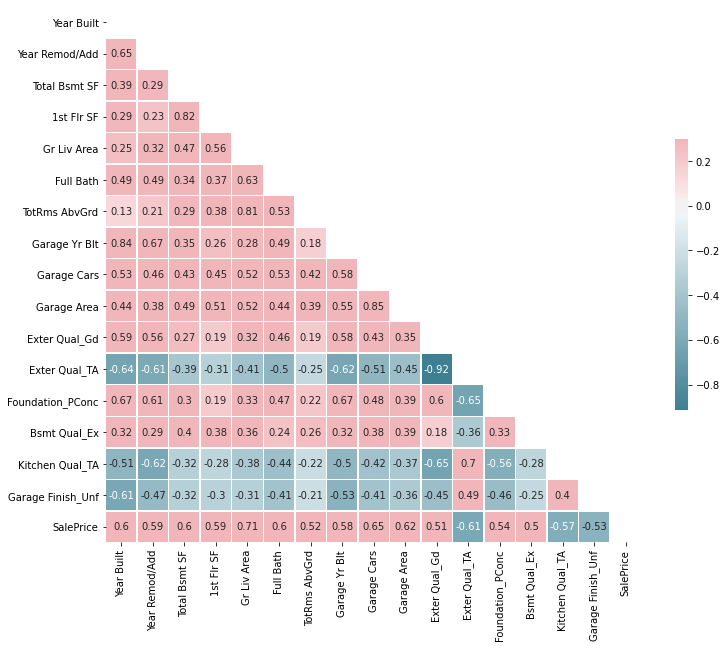

Pearson Correlation Selected Features: Index(['Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'Full Bath',
       'Garage Cars', 'Exter Qual_Gd', 'Foundation_PConc', 'Bsmt Qual_Ex',
       'Kitchen Qual_TA', 'Garage Finish_Unf'],
      dtype='object')

KNN Stepwise Selected Features: ('Year Built', 'Year Remod/Add', 'BsmtFin SF 2', 'Total Bsmt SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', '3Ssn Porch', 'Pool Area', 'Lot Shape_IR1')
Mean Squared Error: 0.039236249719128403

Best alpha using built-in LassoCV: 1.000000
Best score using built-in LassoCV: 0.751599
Lasso picked 13 variables and eliminated the other 313 variables
Variables    Coefficient
Misc Val         -5.369166e-05
Lot Area          2.886550e-07
1st Flr SF        3.808445e-06
BsmtFin SF 2      4.454251e-06
BsmtFin SF 1      5.129051e-05
Mas Vnr Area      7.446322e-05
Screen Porch      1.312447e-04
Total Bsmt SF     1.528737e-04
Wood Deck SF      1.546238e-04
Garage Area       2.814980e-04
Gr Liv Area       3.31658

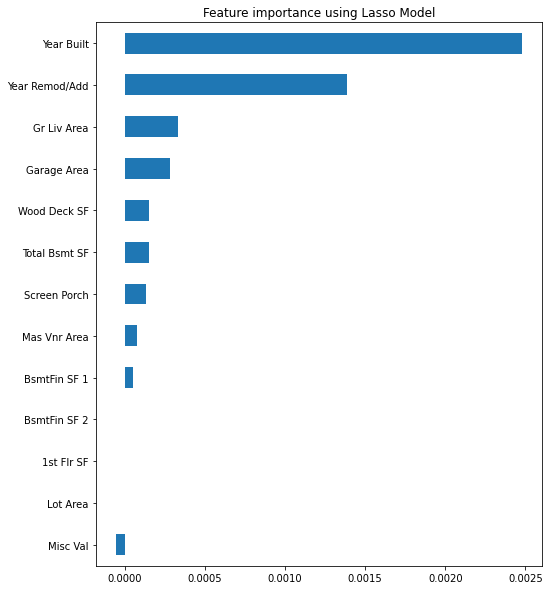


Best alpha using built-in ElasticNetCV: 1.000000
Best l1_ratio using built-in ElasticNetCV: 0.500000
Best score using built-in ElasticNetCV: 0.769377
ElasticNet picked 15 variables and eliminated the other 311 variables
Variables    Coefficient
Pool Area        -1.138613e-04
Misc Val         -5.418339e-05
Lot Area          7.136888e-07
Enclosed Porch    9.588023e-06
1st Flr SF        1.699539e-05
BsmtFin SF 2      3.301683e-05
BsmtFin SF 1      5.293856e-05
Mas Vnr Area      7.895556e-05
Total Bsmt SF     1.304833e-04
Wood Deck SF      1.628261e-04
Garage Area       2.469802e-04
Gr Liv Area       3.197406e-04
Screen Porch      3.247319e-04
Year Remod/Add    2.657662e-03
Year Built        2.722507e-03
dtype: float64


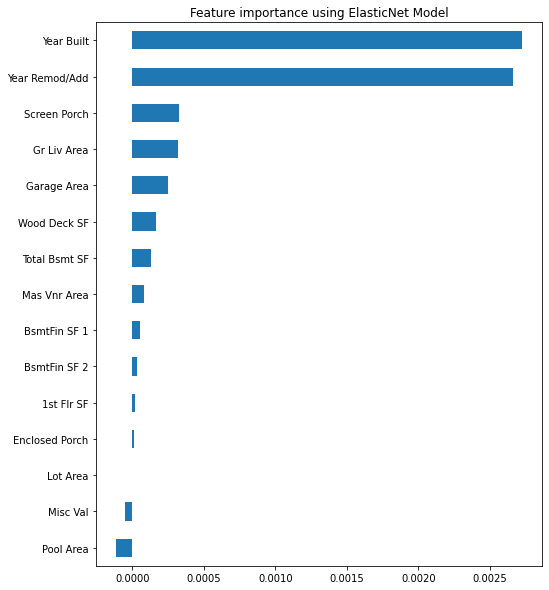


Random Forest picked 
Variable: Year Built                Importance: 0.3
Variable: Gr Liv Area               Importance: 0.22
Variable: 1st Flr SF                Importance: 0.05
Variable: Garage Area               Importance: 0.05
Variable: Exter Qual_TA             Importance: 0.05
Variable: Total Bsmt SF             Importance: 0.04
Variable: Fireplaces                Importance: 0.04
Variable: Garage Cars               Importance: 0.03
Variable: Bsmt Qual_Ex              Importance: 0.03
Variable: Lot Area                  Importance: 0.02

Linear Regression

Mean Squared Error: 0.03690541569652307
Fitting linear regression

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


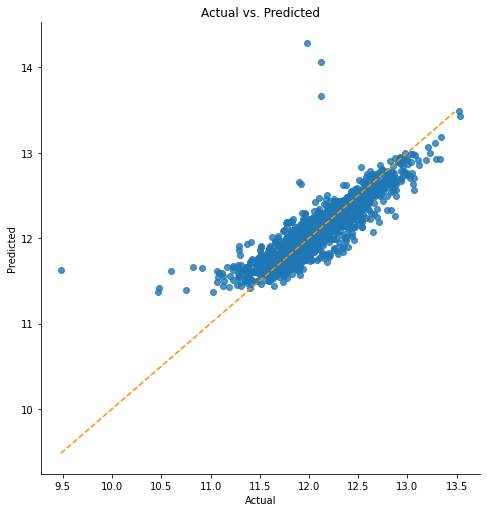

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed



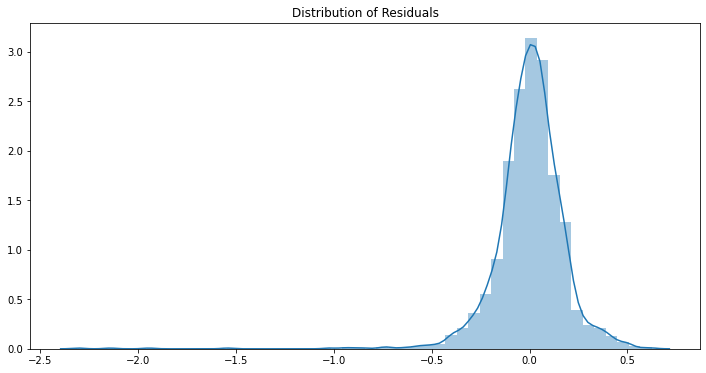

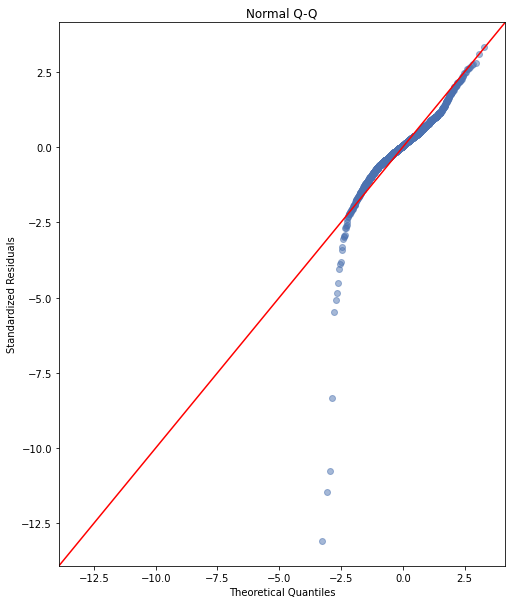


Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Year Built: 32.04194003611494
Total Bsmt SF: 10.488558681525822
Gr Liv Area: 19.327144896862386
Full Bath: 19.29198036548872
Garage Cars: 16.837185465331217
Exter Qual_Gd: 3.346975989135664
Foundation_PConc: 3.7340840846380443
Bsmt Qual_Ex: 1.4950135984560897
Kitchen Qual_TA: 3.9552844152129754
Garage Finish_Unf: 2.576771133420683

5 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 

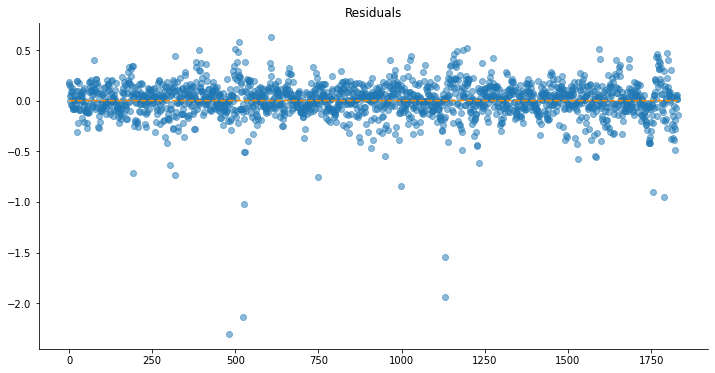

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

KNN Regression

Best parameter: {'n_neighbors': 5}
Mean Squared Error: 0.039236249719128403

Lasso Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.039763264951603136

ElasticNet Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.03962205354855778

Random Forest Regression

Best parameter: {'n_estimators': 500}
Mean Squared Error: 0.02562703866615699
                                mse        r2       mae         v
linear_regression          0.031022   0.81679  0.123967  0.818517
knn_regression            0.0383578  0.773466  0.138027  0.779346
lasso_regression          0.0266145   0.84282  0.117656  0.844879
elasticnet_regression     0.0267577  0.841974  0.118064  0.844405
random_forest_regression  0.0279722  0.834801  0.112916  0.837403

Feature Selection

Year Built           0.604362
Year Remod/Add       0.590092
Total Bsmt SF        0.608203
1st Flr SF       

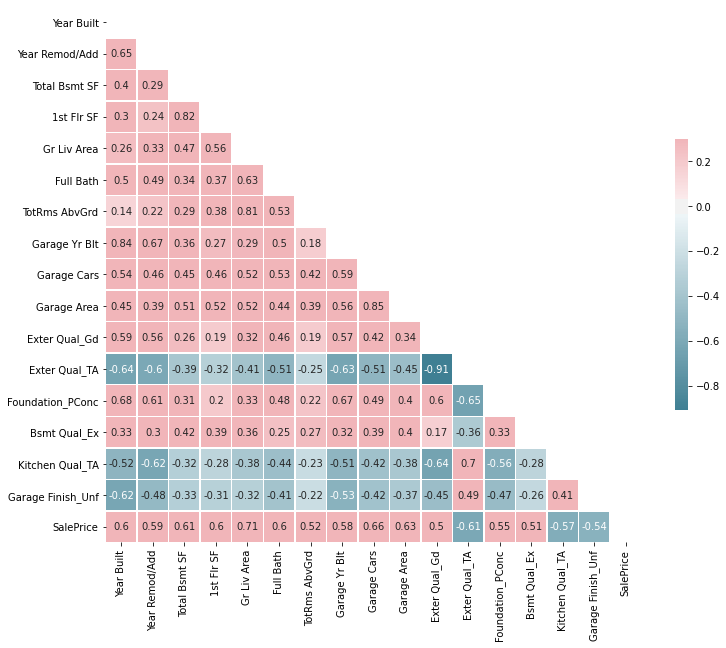

Pearson Correlation Selected Features: Index(['Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'Full Bath',
       'Garage Cars', 'Exter Qual_Gd', 'Foundation_PConc', 'Bsmt Qual_Ex',
       'Kitchen Qual_TA', 'Garage Finish_Unf'],
      dtype='object')

KNN Stepwise Selected Features: ('Lot Frontage', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Yr Blt', '3Ssn Porch', 'Pool Area', 'Mo Sold', 'Sale Condition_Normal')
Mean Squared Error: 0.037959502116355556

Best alpha using built-in LassoCV: 1.000000
Best score using built-in LassoCV: 0.758102
Lasso picked 12 variables and eliminated the other 314 variables
Variables    Coefficient
Misc Val         -5.413261e-05
Lot Area          2.153585e-07
1st Flr SF        3.083245e-06
BsmtFin SF 1      5.560174e-05
Mas Vnr Area      7.083934e-05
Screen Porch      1.174080e-04
Wood Deck SF      1.452974e-04
Total Bsmt SF     1.576519e-04
Garage Area       2.872165e-04
Gr Liv Area       3.355577e-04
Year Remod/Add    1.385688

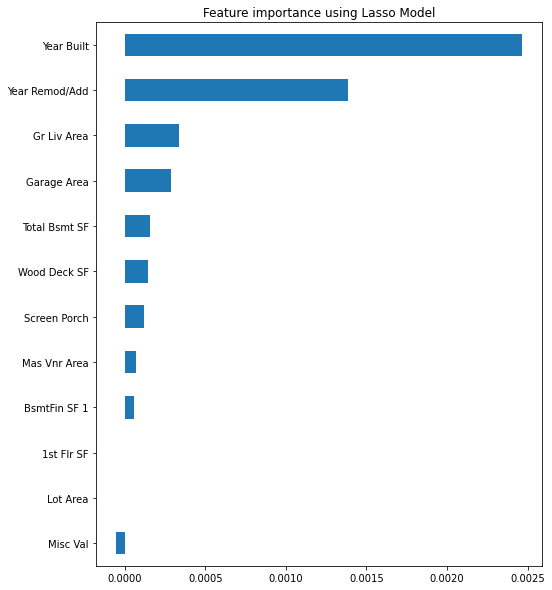


Best alpha using built-in ElasticNetCV: 1.000000
Best l1_ratio using built-in ElasticNetCV: 0.500000
Best score using built-in ElasticNetCV: 0.775614
ElasticNet picked 15 variables and eliminated the other 311 variables
Variables    Coefficient
Pool Area        -1.112226e-04
Misc Val         -5.472294e-05
Lot Area          6.547806e-07
Enclosed Porch    1.062041e-05
1st Flr SF        1.621171e-05
BsmtFin SF 2      2.820058e-05
BsmtFin SF 1      5.668367e-05
Mas Vnr Area      7.569588e-05
Total Bsmt SF     1.353819e-04
Wood Deck SF      1.547841e-04
Garage Area       2.504922e-04
Screen Porch      3.125832e-04
Gr Liv Area       3.234125e-04
Year Remod/Add    2.649496e-03
Year Built        2.717065e-03
dtype: float64


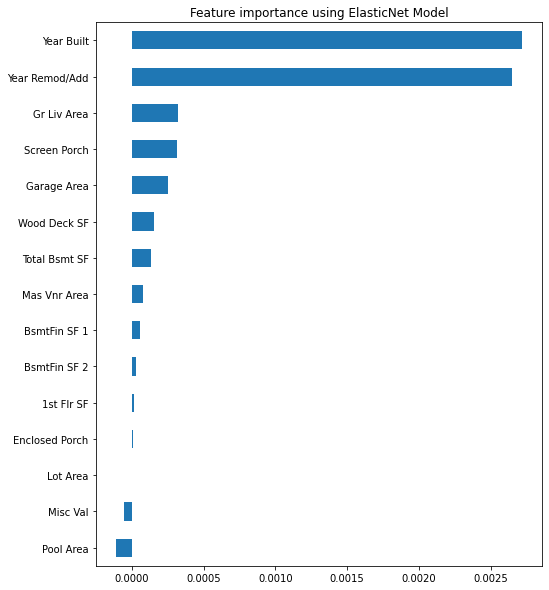


Random Forest picked 
Variable: Year Built                Importance: 0.35
Variable: Gr Liv Area               Importance: 0.2
Variable: Garage Cars               Importance: 0.05
Variable: Total Bsmt SF             Importance: 0.04
Variable: 1st Flr SF                Importance: 0.04
Variable: Fireplaces                Importance: 0.04
Variable: Garage Area               Importance: 0.04
Variable: Bsmt Qual_Ex              Importance: 0.03
Variable: Lot Area                  Importance: 0.02

Linear Regression

Mean Squared Error: 0.03683339084397326
Fitting linear regression

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


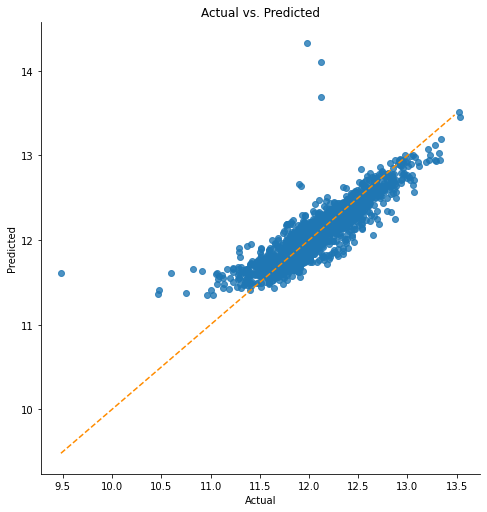

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed



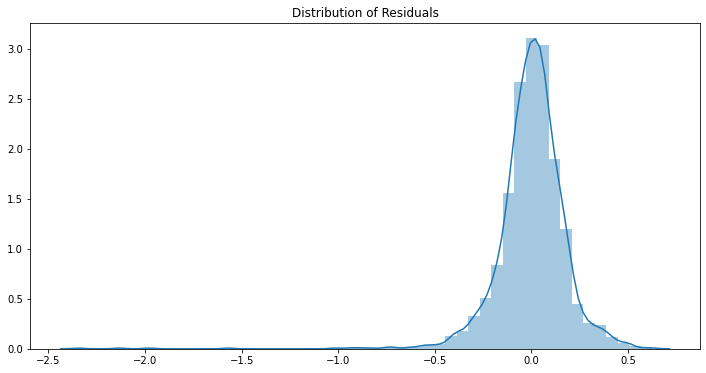

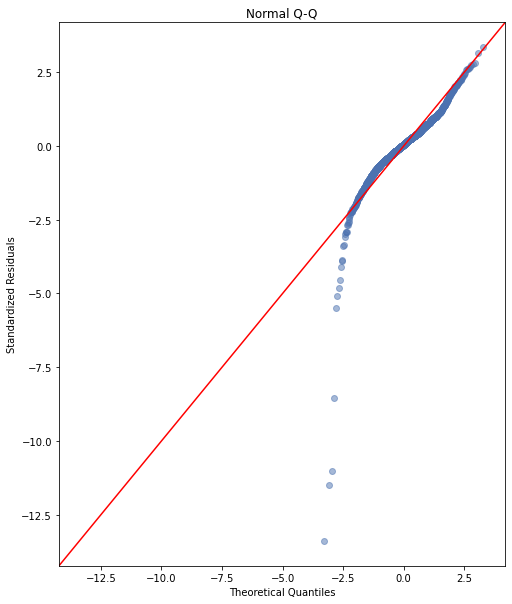


Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Year Built: 32.45884049196727
Total Bsmt SF: 10.573165526382276
Gr Liv Area: 19.35388307292805
Full Bath: 19.485317699748407
Garage Cars: 17.089060423652374
Exter Qual_Gd: 3.321483479946241
Foundation_PConc: 3.795338369803669
Bsmt Qual_Ex: 1.5207131897412078
Kitchen Qual_TA: 3.963830302561031
Garage Finish_Unf: 2.5938870296618384

5 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 i

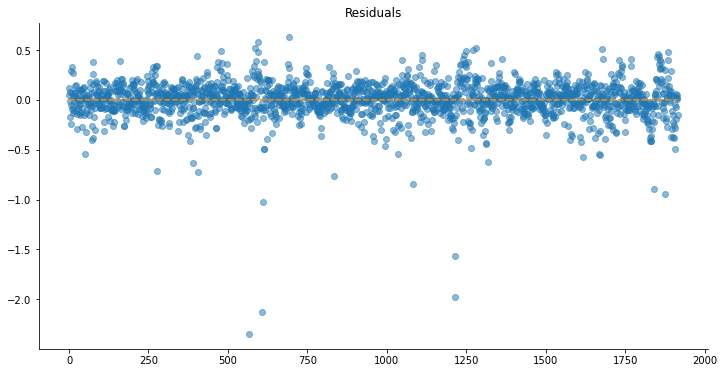

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

KNN Regression

Best parameter: {'n_neighbors': 5}
Mean Squared Error: 0.037959502116355556

Lasso Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.039679956265494434

ElasticNet Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.03953457102436052

Random Forest Regression

Best parameter: {'n_estimators': 500}
Mean Squared Error: 0.025982245543836175
                                mse        r2       mae         v
linear_regression         0.0275531  0.826592   0.12119  0.827765
knn_regression            0.0393876   0.75211  0.141851  0.755822
lasso_regression          0.0268618  0.830942  0.122708  0.832671
elasticnet_regression     0.0268874  0.830781  0.122147  0.832971
random_forest_regression  0.0270817  0.829558  0.114103  0.830308

Feature Selection

Year Built           0.600779
Year Remod/Add       0.584697
Total Bsmt SF        0.611851
1st Flr SF      

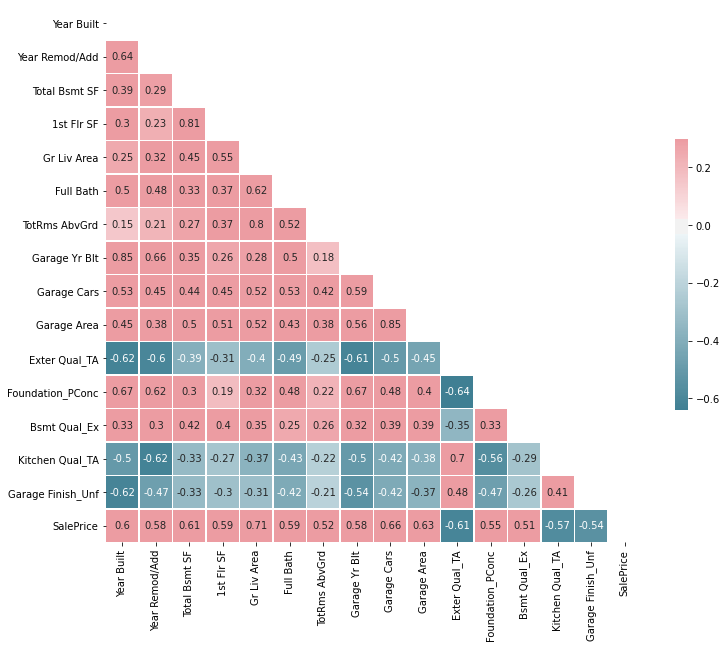

Pearson Correlation Selected Features: Index(['Year Built', 'Total Bsmt SF', 'Gr Liv Area', 'Full Bath',
       'Garage Cars', 'Exter Qual_TA', 'Foundation_PConc', 'Bsmt Qual_Ex',
       'Kitchen Qual_TA', 'Garage Finish_Unf'],
      dtype='object')

KNN Stepwise Selected Features: ('Lot Frontage', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Yr Blt', '3Ssn Porch', 'Pool Area', 'Mo Sold')
Mean Squared Error: 0.03697340764574774

Best alpha using built-in LassoCV: 1.000000
Best score using built-in LassoCV: 0.761470
Lasso picked 13 variables and eliminated the other 313 variables
Variables    Coefficient
Misc Val         -5.375444e-05
Bsmt Unf SF      -3.768742e-08
Lot Area          8.257211e-07
2nd Flr SF        4.970294e-06
BsmtFin SF 1      5.767310e-05
Mas Vnr Area      6.903776e-05
Screen Porch      9.753674e-05
Wood Deck SF      1.445496e-04
Total Bsmt SF     1.688607e-04
Garage Area       2.848485e-04
Gr Liv Area       3.318140e-04
Ye

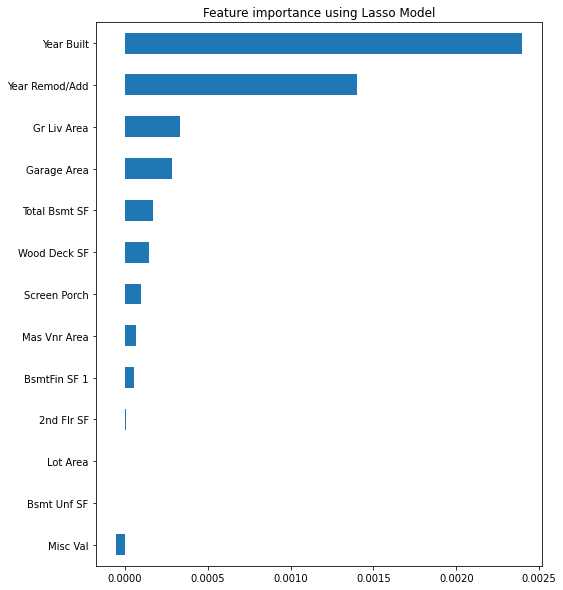


Best alpha using built-in ElasticNetCV: 1.000000
Best l1_ratio using built-in ElasticNetCV: 0.500000
Best score using built-in ElasticNetCV: 0.778934
ElasticNet picked 15 variables and eliminated the other 311 variables
Variables    Coefficient
Pool Area        -8.321257e-05
Misc Val         -5.436534e-05
Bsmt Unf SF      -3.660091e-07
Lot Area          1.210561e-06
2nd Flr SF        1.403275e-06
BsmtFin SF 2      2.808129e-05
BsmtFin SF 1      5.866724e-05
Mas Vnr Area      7.563333e-05
Wood Deck SF      1.519234e-04
Total Bsmt SF     1.519537e-04
Garage Area       2.520054e-04
Screen Porch      2.931927e-04
Gr Liv Area       3.243848e-04
Year Built        2.639726e-03
Year Remod/Add    2.669956e-03
dtype: float64


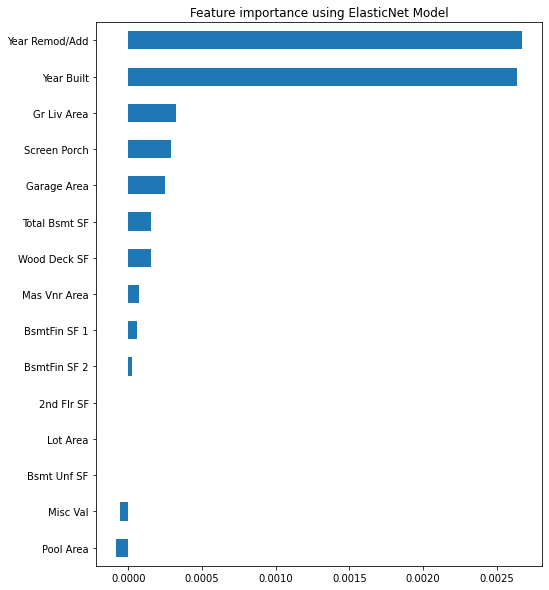


Random Forest picked 
Variable: Year Built                Importance: 0.36
Variable: Gr Liv Area               Importance: 0.17
Variable: Garage Cars               Importance: 0.08
Variable: Total Bsmt SF             Importance: 0.04
Variable: 1st Flr SF                Importance: 0.04
Variable: Fireplaces                Importance: 0.04
Variable: Lot Area                  Importance: 0.02
Variable: Garage Area               Importance: 0.02
Variable: Exter Qual_TA             Importance: 0.02
Variable: Bsmt Qual_Ex              Importance: 0.02

Linear Regression

Mean Squared Error: 0.03489166030687982
Fitting linear regression

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


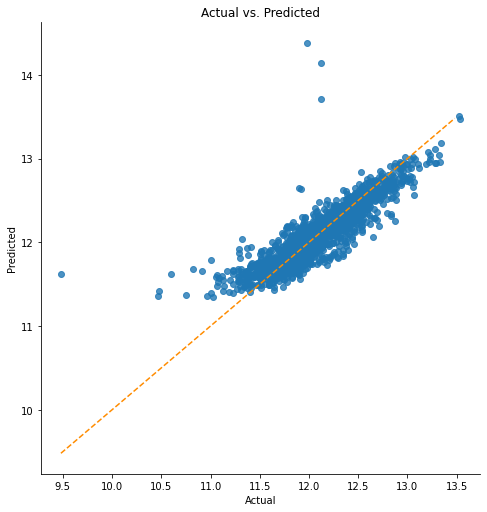

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed



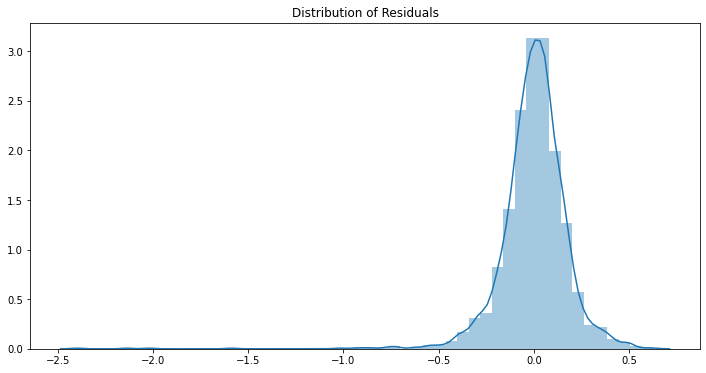

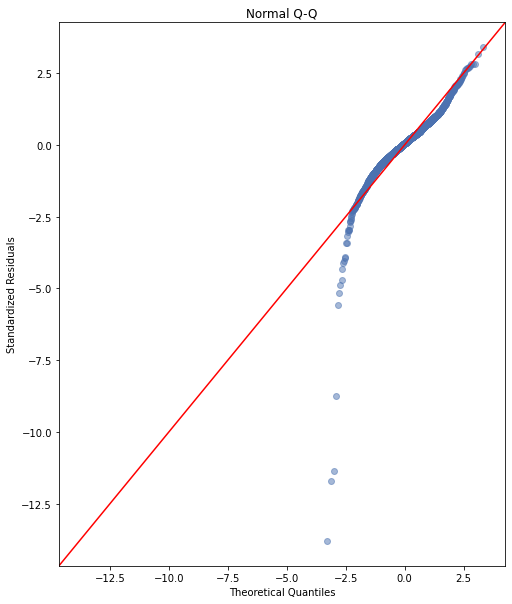


Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Year Built: 38.21190052424011
Total Bsmt SF: 10.300255935966273
Gr Liv Area: 19.632748553395267
Full Bath: 19.421825848561888
Garage Cars: 17.331768844290227
Exter Qual_TA: 6.345419712124728
Foundation_PConc: 3.8365332961956886
Bsmt Qual_Ex: 1.5018171511146197
Kitchen Qual_TA: 4.16295999132212
Garage Finish_Unf: 2.582585174353843

5 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 i

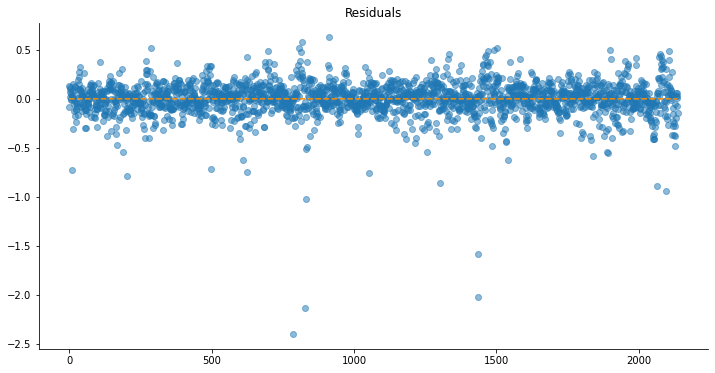

If heteroscedasticity is apparent, confidence intervals and predictions will be affected

KNN Regression

Best parameter: {'n_neighbors': 7}
Mean Squared Error: 0.036662514729739006

Lasso Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.037402517593254817

ElasticNet Regression

Best parameter: {'alpha': 1e-10}
Mean Squared Error: 0.037705163611049385

Random Forest Regression

Best parameter: {'n_estimators': 1000}
Mean Squared Error: 0.0258671886477888
                                mse        r2       mae         v
linear_regression         0.0396615  0.785545   0.12906  0.787393
knn_regression            0.0492249  0.733834  0.146575  0.737858
lasso_regression           0.037486  0.797308  0.126689  0.798722
elasticnet_regression     0.0373808  0.797876  0.126444   0.79945
random_forest_regression  0.0387154   0.79066    0.1236  0.791005

Build Model: Random Forest Regression



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Random Forest picked 
Variable: Year Built                Importance: 0.4
Variable: Gr Liv Area               Importance: 0.14
Variable: Garage Cars               Importance: 0.1
Variable: 1st Flr SF                Importance: 0.05
Variable: Total Bsmt SF             Importance: 0.04
Variable: Fireplaces                Importance: 0.03
Variable: Lot Area                  Importance: 0.02
Variable: BsmtFin SF 1              Importance: 0.02
Best parameter: {'n_estimators': 200}
Mean Squared Error: 0.026319439828576215
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from scipy import stats
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import \
    variance_inflation_factor
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

from sklearn.model_selection import cross_val_score, \
    GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import ElasticNetCV, LassoCV, ElasticNet, Lasso,Ridge
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsRegressor


url='http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls'
housing = pd.read_excel(url)

housing = housing.iloc[:, 2:]
print(housing.info())

transform_rate={1:'Very Poor',2:'Poor',3:'Fair',4:'Below Average',
                5:'Average', 6:'Above Average',7:'Good',8:'Very Good',
                9:'Excellent',10:'Very Excellent'}

transform_subclass={20:'1-STORY 1946 & NEWER ALL STYLES',30:'1-STORY 1945 & '
                    'OLDER', 40:'1-STORY W/FINISHED ATTIC ALL AGES',
                    45:'1-1/2 STORY - UNFINISHED ALL AGES', 50:'1-1/2 STORY '
                    'FINISHED ALL AGES',60:'2-STORY 1946 & NEWER',
                    70:'2-STORY 1945 & OLDER',75:'2-1/2 STORY ALL AGES',
                    80:'SPLIT OR MULTI-LEVEL',85:'SPLIT FOYER', 90:'DUPLEX - '
                    'ALL STYLES AND AGES',120:'1-STORY PUD (Planned Unit '
                                              'Development) - 1946 & NEWER',
                    150:'1-1/2 STORY PUD - ALL AGES',160:'2-STORY PUD - 1946 '
                    '& NEWER',180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                    190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

housing['Overall Qual'] = housing['Overall Qual'].map(transform_rate)
housing['Overall Cond'] = housing['Overall Cond'].map(transform_rate)
housing['MS SubClass'] = housing['MS SubClass'].map(transform_subclass)


housing['Overall Qual'] = housing['Overall Qual'].astype(CategoricalDtype(
    categories = ['Very Poor','Poor','Fair','Below Average',
                'Average', 'Above Average','Good','Very Good',
                'Excellent','Very Excellent'],ordered=True))
housing['Overall Cond'] = housing['Overall Cond'].astype(CategoricalDtype(
    categories = ['Very Poor','Poor','Fair','Below Average',
                'Average', 'Above Average','Good','Very Good',
                'Excellent','Very Excellent'],ordered=True))


housing = housing.drop(
    ['Alley', 'Pool QC', 'Fence', 'Misc Feature', 'Fireplace Qu'], axis=1)

# Change categorical variables from object type to category type
for column in housing.select_dtypes(['object']).columns:
    housing[column] = housing[column].astype('category')


columns = list(housing.iloc[:, :-1].columns)
for column in columns:
    if str(housing[column].dtypes) != 'category':
        housing.plot(kind='scatter', x=column, y='SalePrice')
        print(column)
        plt.show()

housing.SalePrice.plot(kind='box')
plt.title('Distribution of SalePrice')
plt.show()

housing.SalePrice.plot(kind='hist',bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()

# logarithm transformation
housing.SalePrice=np.log(housing.SalePrice)
housing.SalePrice.plot(kind='hist',bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()



def data_cleaning(train):
    # These NA's indicate that the house just doesn't have it
    empty_means_without = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
                           'BsmtFin Type 1',
                           'BsmtFin Type 2',
                           'Garage Type', 'Garage Finish', 'Garage Qual',
                           'Garage '
                           'Cond']
    for feature in empty_means_without:
        train[feature].cat.add_categories(['None'], inplace=True)
        train[feature].fillna('None', inplace=True)
    train['Mas Vnr Type'].fillna('None', inplace=True)
    train['Mas Vnr Area'].fillna(0, inplace=True)
    # Replace NA's in numeric variables with the mean
    train['Lot Frontage'].fillna(train['Lot Frontage'].mean(), inplace=True)
    # treat outlier and missing value for 'Garage Yr Blt'
    # change 2207 to 2007 as it is an error
    train['Garage Yr Blt'][train['Garage Yr Blt'] == 2207] = 2007
    # Set NAs to 2999
    train['Garage Yr Blt'][train['Garage Cars'] == 0].fillna(2999, inplace=True)

    train.dropna(inplace=True)  # Drop any remaining NA's
    return train


def data_trans(test):
    # These NA's indicate that the house just doesn't have it
    empty_means_without = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
                           'BsmtFin Type 1',
                           'BsmtFin Type 2',
                           'Garage Type', 'Garage Finish', 'Garage Qual',
                           'Garage '
                           'Cond']
    for feature in empty_means_without:
        test[feature].cat.add_categories(['None'], inplace=True)
        test[feature].fillna('None', inplace=True)
    test['Mas Vnr Type'].fillna('None', inplace=True)
    test['Mas Vnr Area'].fillna(0, inplace=True)

    # Set NAs to 2999
    test['Garage Yr Blt'][test['Garage Cars'] == 0].fillna(2999, inplace=True)

    return test


# 6 training and test splits
housing['YearMonth'] = housing['Yr Sold'] * 100 + housing['Mo Sold']



def training_test_split(start_date, end_date):
    train = housing[housing['YearMonth'] < start_date].drop(['YearMonth'],
                                                            axis=1)
    test = housing[(housing['YearMonth'] >= start_date) & (housing[
                                                               'YearMonth'] < end_date)].drop(
        ['YearMonth'], axis=1)

    train = data_cleaning(train)
    test = data_trans(test)
    return (train, test)



train_1, test_1 = training_test_split(200804, 200904)
train_2, test_2 = training_test_split(200807, 200907)
train_3, test_3 = training_test_split(200810, 200910)
train_4, test_4 = training_test_split(200901, 201001)
train_5, test_5 = training_test_split(200904, 201004)
train_6, test_6 = training_test_split(200907, 201007)


housing = housing.drop(['YearMonth'],axis=1)
print('housing')
print(housing.info())

def linear_regression_assumptions(features, label, feature_names):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """

    print('Fitting linear regression')
    # generate OLS model
    model = sm.OLS(label, sm.add_constant(features))
    model_fit = model.fit()

    print('\nPerforming linear regression assumption testing')

    # Creating predictions and calculating residuals for assumption tests
    predictions = model_fit.fittedvalues
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})

    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal

    """
    Linearity: Assumes there is a linear relationship between the predictors and
               the response variable.

    """
    print(
        '\n=======================================================================================')
    print(
        'Assumption 1: Linear Relationship between the Target and the Features')

    print(
        'Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')

    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False,
               height=7)

    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    print('If non-linearity is apparent, consider adding a polynomial term')

    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.

    """
    print(
        '\n=======================================================================================')
    print('Assumption 2: The error terms are normally distributed')
    print()

    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(model_residuals)
    plt.show()

    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals')
    plt.show()

    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
    """
    print(
        '\n=======================================================================================')
    print('Assumption 3: Little to no multicollinearity among predictors')
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')

    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in
           range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))

    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(
        possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(
        definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print(
                'Consider removing variables with a high Variance Inflation Factor (VIF)')
    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print(
            'Consider removing variables with a high Variance Inflation Factor (VIF)')
        
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
    """

    print(
        '\n=======================================================================================')
    print('Assumption 4: No Autocorrelation')
    print('\nPerforming Durbin-Watson Test')
    print(
        'Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(model_residuals)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied', '\n')
        print('Consider adding lag variables')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied', '\n')
        print('Consider adding lag variables')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print(
        '\n=======================================================================================')
    print('Assumption 5: Homoscedasticity of Error Terms')
    print('Residuals should have relative constant variance')

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=model_residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange',
             linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()
    print(
        'If heteroscedasticity is apparent, confidence intervals and predictions will be affected')




def pearson_corr_fs(data):
    # Using Pearson Correlation
    cor = data.corr()
    # Correlation with output variable
    cor_target = abs(cor["SalePrice"])
    # Selecting highly correlated features
    relevant_features = cor_target[cor_target > 0.5]
    print(relevant_features)
    # print(relevant_features.index)
    # # features highly correlated with target variable
    df_corr = data[relevant_features.index]
    # Compute the correlation matrix

    corr = df_corr.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()
    # remove highly correlated features
    # Create correlation matrix
    corr_matrix = df_corr.drop('SalePrice',axis=1).corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.8
    to_drop = [column for column in upper.columns if any(upper[column] >=0.8)]
    # Drop features
    df_selected=df_corr.drop(to_drop, axis=1)
    df_selected.drop('Year Remod/Add', axis=1, inplace=True)
    print('Pearson Correlation Selected Features:',df_selected.drop('SalePrice',
            axis=1).columns)
    return df_selected



def linear_regression(data, t):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    X_test = t.drop('SalePrice', axis=1)
    y_test = t.SalePrice
    linear_reg = LinearRegression()
    MSEs = cross_val_score(linear_reg, X, y,
                           scoring='neg_mean_squared_error', cv=10)
    MSE = np.mean(abs(MSEs))
    print('Mean Squared Error:', MSE)
    linear_reg.fit(X, y)
    y_pred = linear_reg.predict(X_test)
    lin_r2 = r2_score(y_test,y_pred)
    lin_mse = mean_squared_error(y_test,y_pred)
    lin_mae = mean_absolute_error(y_test,y_pred)
    lin_v = explained_variance_score(y_test,y_pred)
    return lin_mse, lin_r2,lin_mae,lin_v


def knn_stepwise_fs(data):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    knn = KNeighborsRegressor(n_neighbors=5)
    sfs = SequentialFeatureSelector(knn,
              k_features=10,
              forward=True,
              floating=False,
              scoring='neg_mean_squared_error',
              cv=10)
    sfs.fit(X, y)
    print('KNN Stepwise Selected Features:', sfs.k_feature_names_)
    print('Mean Squared Error:', abs(sfs.k_score_))
    selected_features = list(sfs.k_feature_names_)
    return selected_features


def knn_regression(X, y, X_test, y_test):
    knn = KNeighborsRegressor()
    parameter = {'n_neighbors': [3,4,5,6,7,8,9,10]}

    knn_reg = GridSearchCV(knn,
                      param_grid=parameter,
                      scoring='neg_mean_squared_error',
                      cv=10)
    knn_reg.fit(X, y)
    print('Best parameter:',knn_reg.best_params_)
    print('Mean Squared Error:',abs(knn_reg.best_score_))

    knn = KNeighborsRegressor(n_neighbors = knn_reg.best_params_['n_neighbors'])


    knn.fit(X,y)
    y_pred = knn.predict(X_test)
    knn_r2 = r2_score(y_test,y_pred)
    knn_mse = mean_squared_error(y_test,y_pred)
    knn_mae = mean_absolute_error(y_test,y_pred)
    knn_v = explained_variance_score(y_test,y_pred)

    return knn_mse, knn_r2,knn_mae,knn_v


def ols_regression(data, t):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    X_test = t.drop('SalePrice', axis=1)
    y_test = t.SalePrice
    ols_reg = sm.OLS(y, sm.add_constant(X)).fit()
    y_pred = ols_reg.predict(sm.add_constant(X_test))
    lin_r2 = r2_score(y_test,y_pred)
    lin_mse = mean_squared_error(y_test,y_pred)
    lin_mae = mean_absolute_error(y_test,y_pred)
    lin_v = explained_variance_score(y_test,y_pred)
    return lin_mse, lin_r2,lin_mae,lin_v


def lasso_fs(data):
    # Lasso
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    reg = LassoCV(alphas=[1])
    reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV: %f" % reg.score(X, y))
    coef = pd.Series(reg.coef_, index=X.columns)

    print("Lasso picked " + str(
        sum(coef != 0)) + " variables and eliminated the other " + str(
        sum(coef == 0)) + " variables")
    imp_coef = coef[coef != 0].sort_values()
    print('Variables    Coefficient')
    print(imp_coef)
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using Lasso Model")
    plt.show()
    return imp_coef.index.values.tolist()


def lasso_regression(X, y, X_test, y_test):
    # X = data.drop('SalePrice', axis=1)
    # y = data.SalePrice
    lasso = Lasso()
    parameters = {'alpha': [1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10]}
    lasso_reg = GridSearchCV(lasso, parameters,
                             scoring='neg_mean_squared_error',
                             cv=10)
    lasso_reg.fit(X, y)

    print('Best parameter:',lasso_reg.best_params_)
    print('Mean Squared Error:',abs(lasso_reg.best_score_))

    lasso = Lasso(alpha=lasso_reg.best_params_['alpha'])

    lasso.fit(X, y)
    y_pred = lasso.predict(X_test)
    lasso_r2 = r2_score(y_test,y_pred)
    lasso_mse = mean_squared_error(y_test,y_pred)
    lasso_mae = mean_absolute_error(y_test,y_pred)
    lasso_v = explained_variance_score(y_test,y_pred)
    return lasso_mse, lasso_r2,lasso_mae,lasso_v


def elasticnet_fs(data):
    # elasticnet
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    reg = ElasticNetCV(alphas=[1])
    reg.fit(X, y)
    print("Best alpha using built-in ElasticNetCV: %f" % reg.alpha_)
    print("Best l1_ratio using built-in ElasticNetCV: %f" % reg.l1_ratio_) 
    print("Best score using built-in ElasticNetCV: %f" % reg.score(X, y))
    coef = pd.Series(reg.coef_, index=X.columns)

    print("ElasticNet picked " + str(
        sum(coef != 0)) + " variables and eliminated the other " + str(
        sum(coef == 0)) + " variables")
    imp_coef = coef[coef != 0].sort_values()
    print('Variables    Coefficient')
    print(imp_coef)
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using ElasticNet Model")
    plt.show()
    return imp_coef.index.values.tolist()


def elasticnet_regression(X, y, X_test, y_test):
    # X = data.drop('SalePrice', axis=1)
    # y = data.SalePrice
    elasticnet = ElasticNet()
    parameters = {'alpha': [1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10]}
    elasticnet_reg = GridSearchCV(elasticnet, parameters,
                             scoring='neg_mean_squared_error',
                             cv=10)
    elasticnet_reg.fit(X, y)

    print('Best parameter:',elasticnet_reg.best_params_)
    print('Mean Squared Error:',abs(elasticnet_reg.best_score_))

    elasticnet = ElasticNet(alpha=elasticnet_reg.best_params_['alpha'])

    elasticnet.fit(X, y)
    y_pred = elasticnet.predict(X_test)
    elasticnet_r2 = r2_score(y_test,y_pred)
    elasticnet_mse = mean_squared_error(y_test,y_pred)
    elasticnet_mae = mean_absolute_error(y_test,y_pred)
    elasticnet_v = explained_variance_score(y_test,y_pred)
    return elasticnet_mse, elasticnet_r2,elasticnet_mae,elasticnet_v


def randomforest_fs(data):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators=1000)
    # Train the model on training data
    rf.fit(X, y)
    # Get numerical feature importances
    feature_list = X.columns
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    print('Random Forest picked ')
    feature_importances = [(feature, round(importance, 2)) for
                           feature, importance in
                           zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key=lambda x: x[1],
                                 reverse=True)
    selected_features = []
    # Print out the feature and importances
    for pair in feature_importances:
        if pair[1] > 0.01:
            print('Variable: {:25} Importance: {}'.format(
                *pair))
            selected_features.append(pair[0])
    return selected_features


def randomforest_regression(X, y, X_test, y_test):
    # X = data.drop('SalePrice', axis=1)
    # y = data.SalePrice
    rf = RandomForestRegressor()
    parameters = {'n_estimators': [100, 200, 300, 500, 1000]}
    rf_reg = GridSearchCV(rf, parameters,
                          scoring='neg_mean_squared_error',
                          cv=10)
    rf_reg.fit(X, y)

    print('Best parameter:',rf_reg.best_params_)
    print('Mean Squared Error:',abs(rf_reg.best_score_))

    rf = RandomForestRegressor(n_estimators=rf_reg.best_params_['n_estimators'])

    rf.fit(X, y)
    y_pred = rf.predict(X_test)
    rf_r2 = r2_score(y_test,y_pred)
    rf_mse = mean_squared_error(y_test,y_pred)
    rf_mae = mean_absolute_error(y_test,y_pred)
    rf_v = explained_variance_score(y_test,y_pred)
    return rf_mse, rf_r2,rf_mae,rf_v



def regression_model(dataset,test):
    cor_list = list(dataset.columns)
    cor_list.remove('SalePrice')
    cor_list.append('SalePrice')
    dataset=dataset.reindex(columns=cor_list)
    # Feature selection   
    print(
        '\n=======================================================================================')
    print('Feature Selection')
    print(
        '\n=======================================================================================')
    df_linear = pearson_corr_fs(dataset)
    print(
        '\n=======================================================================================')
    df_knn = dataset[knn_stepwise_fs(dataset)]
    print(
        '\n=======================================================================================')
    df_lasso = dataset[lasso_fs(dataset)]
    print(
        '\n=======================================================================================')
    df_elasticnet = dataset[elasticnet_fs(dataset)]
    print(
        '\n=======================================================================================')
    df_random_forest = dataset[randomforest_fs(dataset)]
    # prepare test dataset
    test_columns = list(set(df_linear.columns) | set(df_knn.columns) | set(
        df_lasso.columns) | set(df_elasticnet.columns) | set(
        df_random_forest.columns))
    test = test[test_columns]
    test.dropna(inplace=True)
    test = test.sample(n=450)

    test_result = pd.DataFrame(columns=['mse', 'r2', 'mae', 'v'])

    # linear regression
    print(
        '\n=======================================================================================')
    print('Linear Regression')
    print(
        '\n=======================================================================================')


    test_linear = test[list(df_linear.columns)]

    test_result.loc['linear_regression', 'mse'], test_result.loc[
        'linear_regression', 'r2'],test_result.loc['linear_regression', 'mae'], \
    test_result.loc['linear_regression', 'v'] = linear_regression(df_linear,
                                                                 test_linear)
    linear_regression_assumptions(df_linear.drop('SalePrice', axis=1).values,
                                  dataset.SalePrice.values, df_linear.drop(
            'SalePrice',
            axis=1).columns)


    # knn regression
    print(
        '\n=======================================================================================')
    print('KNN Regression')
    print(
        '\n=======================================================================================')
    test_columns = list(df_knn.columns)
    test_knn = test[test_columns]

    test_result.loc['knn_regression', 'mse'], test_result.loc[
        'knn_regression', 'r2'],test_result.loc['knn_regression', 'mae'], \
    test_result.loc['knn_regression', 'v'] = knn_regression(df_knn,
                                              dataset.SalePrice,
                                test_knn,
                                test.SalePrice)



    # lasso regression
    print(
        '\n=======================================================================================')
    print('Lasso Regression')
    print(
        '\n=======================================================================================')

    test_columns = list(df_lasso.columns)
    test_lasso = test[test_columns]

    test_result.loc['lasso_regression', 'mse'], test_result.loc['lasso_regression',
                                                              'r2'], \
    test_result.loc['lasso_regression', 'mae'], test_result.loc['lasso_regression',
                                                              'v'] = \
        lasso_regression(df_lasso,
                         dataset.SalePrice, test_lasso,
                         test.SalePrice)

    # elasticnet regression
    print(
        '\n=======================================================================================')
    print('ElasticNet Regression')
    print(
        '\n=======================================================================================')
    
    test_columns = list(df_elasticnet.columns)
    test_elasticnet = test[test_columns]

    test_result.loc['elasticnet_regression', 'mse'], test_result.loc['elasticnet_regression',
                                                              'r2'], \
    test_result.loc['elasticnet_regression', 'mae'], test_result.loc['elasticnet_regression',
                                                              'v'] = \
        elasticnet_regression(df_elasticnet,
                         dataset.SalePrice, test_elasticnet,
                         test.SalePrice)

    # RandomForest
    print(
        '\n=======================================================================================')
    print('Random Forest Regression')
    print(
        '\n=======================================================================================')

    test_columns = list(df_random_forest.columns)
    test_random_forest = test[test_columns]

    test_result.loc['random_forest_regression', 'mse'], test_result.loc[
        'random_forest_regression', 'r2'], test_result.loc[
        'random_forest_regression', 'mae'], test_result.loc[
        'random_forest_regression', 'v'] = \
        randomforest_regression(df_random_forest, dataset.SalePrice,
                                test_random_forest,
                                test.SalePrice)
    print(test_result)



regression_model(pd.get_dummies(train_1),pd.get_dummies(test_1))
regression_model(pd.get_dummies(train_2),pd.get_dummies(test_2))
regression_model(pd.get_dummies(train_3),pd.get_dummies(test_3))
regression_model(pd.get_dummies(train_4),pd.get_dummies(test_4))
regression_model(pd.get_dummies(train_5),pd.get_dummies(test_5))
regression_model(pd.get_dummies(train_6),pd.get_dummies(test_6))


# build the regression model using the best performance model
print('\n=======================================================================================')
print('Build Model: Random Forest Regression')
print('\n=======================================================================================')
# clean data
train = pd.get_dummies(data_cleaning(housing))
# feature selection
df_random_forest = train[randomforest_fs(train)]
# build Random Forest Regression
X = df_random_forest
y = train.SalePrice
rf = RandomForestRegressor()
parameters = {'n_estimators': [100, 200, 300, 500, 1000]}
rf_reg = GridSearchCV(rf, parameters,
                          scoring='neg_mean_squared_error',
                          cv=10)
rf_reg.fit(X, y)

print('Best parameter:',rf_reg.best_params_)
print('Mean Squared Error:',abs(rf_reg.best_score_))

rf = RandomForestRegressor(n_estimators=rf_reg.best_params_['n_estimators'])


rf.fit(X, y)
print(rf)